# Data Preparation

### Import packages

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import mstats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Import utilities

In [2]:
import sys
sys.path.append('../src/')
import utils

disease_cat_map  = utils.disease_cat_map 
condition_cat_map = utils.condition_cat_map

### Import data

Database connection

In [3]:
conn = sqlite3.connect("../data/db/gfm.db")

Primary data data

In [4]:
master = pd.read_sql_query("SELECT * FROM master", conn)

In [5]:
er = pd.read_sql_query("SELECT * FROM er_final", conn)

In [6]:
disease_pivot = pd.read_sql_query("SELECT * FROM disease_pivot", conn)

In [7]:
int_pivot = pd.read_sql_query("SELECT * FROM int_pivot", conn)

In [8]:
primary_cat = pd.read_sql_query("SELECT * FROM primary_cat", conn)

In [9]:
shares = pd.read_csv("../data/social_media_shares/social_media_shares.csv")

Additional geographic data

In [10]:
state_pop = pd.read_csv('../data/census/state_pop.csv')

In [11]:
census_regions = pd.read_csv('../data/census/census_regions.csv')

Donation data

In [12]:
#d = pd.read_sql_query("SELECT * FROM donation_tb", conn)

### Clean data

Primary disease category

In [13]:
del primary_cat['index']
primary_cat.columns = ['url','primary_disease_cat','primary_int_cat']

In [14]:
primary_disease_dummy = pd.get_dummies(primary_cat['primary_disease_cat'])
cols = primary_disease_dummy.columns.str.lower().str.replace(' ','_').str.replace(',','')
cols = ['pd_' + x for x in cols]
primary_disease_dummy.columns = cols
primary_disease_dummy['url'] = primary_cat['url']

Primary intermediate category (aka condition)

In [15]:
primary_cond_dummy = pd.get_dummies(primary_cat['primary_int_cat'])
cols = primary_cond_dummy.columns.str.lower().str.replace(' ','_').str.replace(',','')
cols = ['pc_' + x for x in cols]
primary_cond_dummy.columns = cols
primary_cond_dummy['url'] = primary_cat['url']

Disease category, not mutually exclusive

In [16]:
del disease_pivot['index']
cols = disease_pivot.columns
cols = ['d_' + x for x in cols]
cols[0] = 'url'
disease_pivot.columns = cols

In [17]:
disease_pivot['d_cardiovascular_diseases'] = disease_pivot['d_cardiovascular_diseases'].astype('category')
disease_pivot['d_endocrine_diseases'] = disease_pivot['d_endocrine_diseases'].astype('category')
disease_pivot['d_gastrointestinal_diseases'] = disease_pivot['d_gastrointestinal_diseases'].astype('category')
disease_pivot['d_genitourinary_diseases'] = disease_pivot['d_genitourinary_diseases'].astype('category')
disease_pivot['d_infections'] = disease_pivot['d_infections'].astype('category')
disease_pivot['d_injuries_and_external_causes'] = disease_pivot['d_injuries_and_external_causes'].astype('category')
disease_pivot['d_mental_behavioral_and_substance_use_disorders'] = disease_pivot['d_mental_behavioral_and_substance_use_disorders'].astype('category')
disease_pivot['d_musculoskeletal_diseases'] = disease_pivot['d_musculoskeletal_diseases'].astype('category')
disease_pivot['d_neoplasms'] = disease_pivot['d_neoplasms'].astype('category')
disease_pivot['d_nervous_system_diseases'] = disease_pivot['d_nervous_system_diseases'].astype('category')
disease_pivot['d_respiratory_diseases'] = disease_pivot['d_respiratory_diseases'].astype('category')

Condition, not mutually exclusive

In [18]:
cols = int_pivot.columns
cols = ['c_' + x for x in cols]
cols[0] = 'url'
int_pivot.columns = cols

Add financial variables

In [19]:
master.loc[:,'per_raised'] = (master['current_amount']/master['goal_amount']).round(2) * 100
master.loc[:,'hit_goal'] = [1 if x >= 100 else 0 for x in master['per_raised']]

Recode NDI quantile as categorical

In [20]:
master['ndi_quantile'] = master['ndi_quantile'].astype('category')

### Merge data

In [21]:
master = master.merge(primary_cat, on='url', how='left')

In [22]:
master = master.merge(primary_disease_dummy, on='url', how='left')

In [23]:
master = master.merge(primary_cond_dummy, on='url', how='left')

In [24]:
master = master.merge(disease_pivot, on='url', how='left')
master.loc[:,list(disease_pivot.columns[1:])] = master.loc[:,list(disease_pivot.columns[1:])].fillna(0)

In [25]:
master = master.merge(int_pivot, on='url', how='left')
master.loc[:,list(int_pivot.columns[1:])] = master.loc[:,list(int_pivot.columns[1:])].fillna(0)

### Apply exclusions

In [26]:
print(master.shape)

(92288, 112)


In [27]:
#remove non-english campaigns
master = master[master['language'] == 'en']
print(master.shape)

(89732, 112)


In [28]:
#remove campaigns with currency != USD
master = master[master['currencycode'] == 'USD']
print(master.shape)

(89707, 112)


In [29]:
#remove campaigns with "research" in title
master = master[master['research_in_title'] == 0]
print(master.shape)

(89637, 112)


In [283]:
#need to remove really high values for goal amount, current amount, donation count, donation amount

In [284]:
master['current_amount'].quantile([.999])

0.999    134869.276
Name: current_amount, dtype: float64

In [285]:
master['goal_amount'].quantile([.999])

0.999    1000000.0
Name: goal_amount, dtype: float64

In [286]:
master['donation_count'].quantile([.999])

0.999    1496.092
Name: donation_count, dtype: float64

In [287]:
master['donation_mean'].quantile([.999])

0.999    1014.880952
Name: donation_mean, dtype: float64

In [288]:
before = master.shape[0]
master = master[master['current_amount'] < 500000]
after = master.shape[0]
print(before - after)

7


In [289]:
before = master.shape[0]
master = master[master['goal_amount'] < 1000000]
after = master.shape[0]
print(before - after)

131


In [290]:
before = master.shape[0]
master = master[master['donation_count'] < 1500]
after = master.shape[0]
print(before - after)

80


In [291]:
before = master.shape[0]
master = master[master['donation_mean'] < 1000]
after = master.shape[0]
print(before - after)

1951


In [292]:
master.shape

(87468, 112)

In [27]:
# #keep campaigns with identified disease category
# print(master['primary_disease_cat'].isna().sum())
# print(master['primary_int_cat'].isna().sum())

# master = master[~master['primary_disease_cat'].isna()]

# print(master.shape)

# print(master['primary_disease_cat'].isna().sum())
# print(master['primary_int_cat'].isna().sum())

25253
25253
(64216, 144)
0
0


In [28]:
# #subset data to include urls in final sample
# er = er[er['url'].isin(master['url'].tolist())]

# print(er['url'].nunique())

64216


In [29]:
# disease_pivot = disease_pivot[disease_pivot['url'].isin(master['url'].tolist())]

# print(disease_pivot.shape)

(64216, 12)


In [30]:
# int_pivot = int_pivot[int_pivot['url'].isin(master['url'].tolist())]

# print(int_pivot.shape)

(64216, 26)


### Winsorize data

In [360]:
#5th percentile
master.loc[:,'goal_amount_winsor_5'] = mstats.winsorize(master['goal_amount'], limits=[0.05,0.05])
master.loc[:,'current_amount_winsor_5'] = mstats.winsorize(master['current_amount'], limits=[0.05,0.05])
master.loc[:,'donation_count_winsor_5'] = mstats.winsorize(master['donation_count'], limits=[0.05,0.05])
master.loc[:,'donation_amount_winsor_5'] = mstats.winsorize(master['donation_mean'], limits=[0.05,0.05])
master.loc[:,'per_raised_winsor_5'] = mstats.winsorize(master['per_raised'], limits=[0.05,0.05])

#2.5th percentile
master.loc[:,'goal_amount_winsor_25'] = mstats.winsorize(master['goal_amount'], limits=[0.025,0.025])
master.loc[:,'current_amount_winsor_25'] = mstats.winsorize(master['current_amount'], limits=[0.025,0.025])
master.loc[:,'donation_count_winsor_25'] = mstats.winsorize(master['donation_count'], limits=[0.025,0.025])
master.loc[:,'donation_amount_winsor_25'] = mstats.winsorize(master['donation_mean'], limits=[0.025,0.025])
master.loc[:,'per_raised_winsor_25'] = mstats.winsorize(master['per_raised'], limits=[0.025,0.025])

#1st percentile
master.loc[:,'goal_amount_winsor_1'] = mstats.winsorize(master['goal_amount'], limits=[0.01,0.01])
master.loc[:,'current_amount_winsor_1'] = mstats.winsorize(master['current_amount'], limits=[0.01,0.01])
master.loc[:,'donation_count_winsor_1'] = mstats.winsorize(master['donation_count'], limits=[0.01,0.01])
master.loc[:,'donation_amount_winsor_1'] = mstats.winsorize(master['donation_mean'], limits=[0.01,0.01])
master.loc[:,'per_raised_winsor_1'] = mstats.winsorize(master['per_raised'], limits=[0.01,0.01])

# Inspect extreme values

### High values

#### Donation count

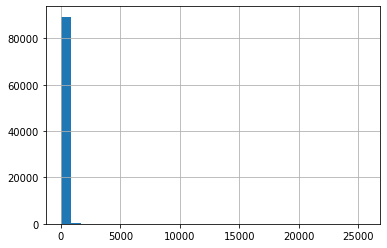

In [32]:
master['donation_count'].hist(bins=30)

In [84]:
master[master['donation_count'] > 10000]

,index,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,created_at,social_share_last_update,...,goal_amount_winsor_25,current_amount_winsor_25,donation_count_winsor_25,donation_amount_winsor_25,per_raised_winsor_25,goal_amount_winsor_1,current_amount_winsor_1,donation_count_winsor_1,donation_amount_winsor_1,per_raised_winsor_1
5554,5554,https://www.gofundme.com/f/vbe3b-covid19-relief,15751,1,USD,883148.0,800000.0,COVID-19 relief for the Coelho Family,2020-03-31T22:14:32-05:00,2020-08-18T14:48:10-05:00,...,100000.0,32925.0,309,54.375000,110.0,200000.0,50300.0,465,54.375,110.0
48918,48918,https://www.gofundme.com/f/salma039s-dream-tra...,25561,1,USD,601070.0,600000.0,Salmas lifesaving transplant,2018-09-01T19:43:58-05:00,2020-08-20T16:44:01-05:00,...,100000.0,32925.0,309,34.790997,100.0,200000.0,50300.0,465,32.262,100.0
62235,62235,https://www.gofundme.com/f/AndyReyes,24029,1,USD,531735.0,800000.0,Instagram:@HelpAndy101 #HelpAndy101,2017-10-06T07:41:41-05:00,2020-08-14T11:11:25-05:00,...,100000.0,32925.0,309,34.790997,66.0,200000.0,50300.0,465,32.310,66.0


#### Donation amount

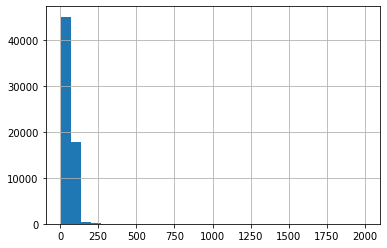

In [93]:
master['don_median'].hist(bins=30)

In [94]:
master['don_median'].describe()

count    63522.000000
mean        61.346715
std         38.268028
min          5.000000
25%         50.000000
50%         50.000000
75%         87.500000
max       2000.000000
Name: don_median, dtype: float64

In [121]:
master[master['don_mean'] > 20000]

,index,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,created_at,social_share_last_update,...,goal_amount_winsor_25,current_amount_winsor_25,donation_count_winsor_25,donation_amount_winsor_25,per_raised_winsor_25,goal_amount_winsor_1,current_amount_winsor_1,donation_count_winsor_1,donation_amount_winsor_1,per_raised_winsor_1
34552,34552,https://www.gofundme.com/f/2a2txg4,88,0,USD,2696160.0,2695000.0,Help Save Suzu Fund,2016-06-17T23:46:16-05:00,2017-08-31T08:24:18-05:00,...,100000.0,32925.0,88,316.722222,100.0,200000.0,50300.0,88,30638.193182,100.0
35679,35679,https://www.gofundme.com/f/88l9zw,29,0,USD,772951.0,1200000.0,Save Our Twisha,2014-04-10T16:33:56-05:00,2017-08-31T10:13:09-05:00,...,100000.0,32925.0,29,316.722222,64.0,200000.0,50300.0,29,25765.033333,64.0


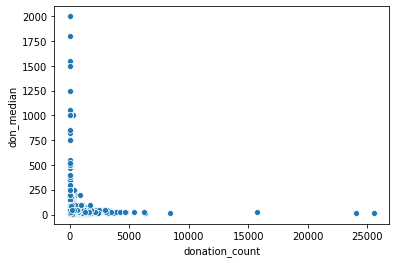

In [99]:
sns.scatterplot(x='donation_count',y='don_median',data=master)

Most campaigns with a high median donation amount have a small number of total donations

In [101]:
d['don_amt']

,don_id,online_id,url,don_amt,don_offline,don_anon,don_name,don_date,don_profile,don_verified
0,1,75288239,https://www.gofundme.com/f/Amarilindo,10.0,0,0,Patrice Whitely,2016-03-13T16:09:18-05:00,,1
1,2,72701479,https://www.gofundme.com/f/Amarilindo,20.0,0,0,cheryl redman,2016-03-03T07:19:35-06:00,,1
2,3,72113923,https://www.gofundme.com/f/Amarilindo,25.0,0,0,Stephanie C,2016-03-01T08:44:25-06:00,,1
3,4,71698975,https://www.gofundme.com/f/Amarilindo,30.0,0,0,Tracy H,2016-02-28T12:22:35-06:00,,1
4,5,71101151,https://www.gofundme.com/f/Amarilindo,50.0,0,0,Yosh Takashima,2016-02-25T18:45:31-06:00,,1


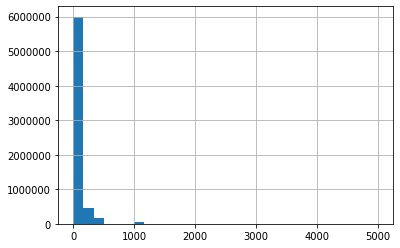

In [109]:
d[d['don_amt'] < 5000]['don_amt'].hist(bins=30)

In [111]:
d['don_amt'].mode()

0    100.0
dtype: float64

#### Current amount

In [141]:
master['current_amount'].quantile(0.999)

135386.46500000157

In [142]:
master[master['current_amount'] >= 135386]

,index,url,donation_count,donor_reached_max,currencycode,current_amount,goal_amount,fund_name,created_at,social_share_last_update,...,goal_amount_winsor_25,current_amount_winsor_25,donation_count_winsor_25,donation_amount_winsor_25,per_raised_winsor_25,goal_amount_winsor_1,current_amount_winsor_1,donation_count_winsor_1,donation_amount_winsor_1,per_raised_winsor_1
2830,2830,https://www.gofundme.com/f/t5wvr-help-for-tomasso,441,0,USD,149005.0,200000.0,Help for Tommaso,2019-09-24T06:15:52-05:00,2020-04-14T16:20:54-05:00,...,100000.0,32925.0,309,316.722222,75.0,200000.0,50300.0,441,337.879819,75.0
4160,4160,https://www.gofundme.com/f/betenderandlaugh,1947,1,USD,184375.0,200000.0,Doyle Family Support Fund,2016-11-21T11:25:40-06:00,2020-04-09T16:06:56-05:00,...,100000.0,32925.0,309,81.730000,92.0,200000.0,50300.0,465,81.730000,92.0
4558,4558,https://www.gofundme.com/f/x6y9mm9c-cindys-bat...,987,0,USD,148201.0,200000.0,CINDY'S BATTLE WITH ALS,2017-01-30T19:16:16-06:00,2020-08-17T09:18:45-05:00,...,100000.0,32925.0,309,150.152989,74.0,200000.0,50300.0,465,150.152989,74.0
5554,5554,https://www.gofundme.com/f/vbe3b-covid19-relief,15751,1,USD,883148.0,800000.0,COVID-19 relief for the Coelho Family,2020-03-31T22:14:32-05:00,2020-08-18T14:48:10-05:00,...,100000.0,32925.0,309,54.375000,110.0,200000.0,50300.0,465,54.375000,110.0
5814,5814,https://www.gofundme.com/f/z2h9nhdw,2560,1,USD,169154.0,175000.0,The Vaillancourt Family,2016-01-02T21:21:49-06:00,2020-04-25T21:49:40-05:00,...,100000.0,32925.0,309,66.731000,97.0,175000.0,50300.0,465,66.731000,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89112,89112,https://www.gofundme.com/f/y4u42w-atlas-family,1322,1,USD,164821.0,225000.0,Atlas Family,2020-07-25T21:14:32-05:00,2020-08-17T21:59:54-05:00,...,100000.0,32925.0,309,114.578000,73.0,200000.0,50300.0,465,114.578000,73.0
89430,89430,https://www.gofundme.com/f/andrea-pappas-camut...,1207,1,USD,156526.0,100000.0,Andrea Pappas Camuto & Baby Blake,2018-11-13T14:47:50-06:00,2020-05-16T01:15:29-05:00,...,100000.0,32925.0,309,125.473000,157.0,100000.0,50300.0,465,125.473000,157.0
89888,89888,https://www.gofundme.com/f/support-chelsea-ell...,2953,1,USD,332008.0,515000.0,Support Chelsea Ellis's Mission To Recovery,2020-05-29T14:54:07-05:00,2020-08-20T20:24:20-05:00,...,100000.0,32925.0,309,100.714000,64.0,200000.0,50300.0,465,100.714000,64.0
91467,91467,https://www.gofundme.com/f/newlegnewjourney,1321,1,USD,137420.0,130000.0,"A New Leg, A New Journey",2016-09-01T08:11:03-05:00,2020-08-07T12:00:59-05:00,...,100000.0,32925.0,309,113.915000,106.0,130000.0,50300.0,465,113.915000,106.0


### Low values

#### Zero donations

In [127]:
[x for x in master[master['donation_count'] == 0].sample(10)['url']]

['https://www.gofundme.com/f/23l10td740',
 'https://www.gofundme.com/f/unbreakablepeter',
 'https://www.gofundme.com/f/hadeel-khoury-need-help-for-surgery',
 'https://www.gofundme.com/f/charlie-daniels-tribute-in-support-of-our-military',
 'https://www.gofundme.com/f/help-for-food-and-treatment',
 'https://www.gofundme.com/f/buyma-please-help-my-babies',
 'https://www.gofundme.com/f/kashi-the-medical-alert-service-pup',
 'https://www.gofundme.com/f/help-o-get-top-surgery',
 'https://www.gofundme.com/f/skylers-fundraiser',
 'https://www.gofundme.com/f/kq764-medical-bills']

Manually reviewed a small sample; all of them appear to be campaigns reflecting a genuine medical need.

In [137]:
master[master['donation_count'] == 0].shape

(674, 159)

In [140]:
674/master.shape[0]

0.010495826585274698

# Tabulation and visualization

In [243]:
def fp(var, sort_idx=False):
    if sort_idx:
        df = pd.concat([master[var].value_counts(),master[var].value_counts(normalize=True)*100], axis=1).sort_index()
    else:
        df = pd.concat([master[var].value_counts(),master[var].value_counts(normalize=True)*100], axis=1)
    df.columns = ['freq','percent']
    return df

### Table 1

#### Number of unique disease categories per campaign

In [241]:
master['any_disease_sum'] = master[master.columns[master.columns.str.startswith('d_')]].apply(lambda x: x.sum(), axis=1)

In [244]:
any_disease_sum = fp('any_disease_sum', True)

In [245]:
any_disease_sum.iloc[:3,]

,freq,percent
0,24043,27.487767
1,46551,53.220606
2,11895,13.599259


In [246]:
#3+ categories
any_disease_sum.iloc[3:,].apply(lambda x: sum(x), axis=0)

freq       4979.000000
percent       5.692367
dtype: float64

#### Frequency of census regions

In [247]:
fp('census_region')

,freq,percent
South,32583,37.251338
West,23344,26.688618
Midwest,17689,20.223396
Northeast,13852,15.836649


#### Frequency of neighborhood deprivation index quartile

In [293]:
fp('ndi_quantile')

,freq,percent
1.0,53814,61.524215
2.0,19177,21.924590
3.0,10597,12.115288
4.0,3880,4.435908


#### Frequency of year

In [248]:
fp('year', True)

,freq,percent
2010,6,0.006860
2011,30,0.034298
2012,113,0.129190
2013,938,1.072392
2014,6637,7.587918
2015,16368,18.713129
2016,13094,14.970046
2017,10179,11.637399
2018,11204,12.809256
2019,15683,17.929986


#### Supp table 1 - Number of unique conditions per campaign

In [138]:
master['any_condition_sum'] = master[master.columns[master.columns.str.startswith('c_')]].apply(lambda x: x.sum(), axis=1)

In [139]:
any_condition_sum = fp('any_condition_sum', True)

In [140]:
any_condition_sum.iloc[:3,]

,freq,percent
0.0,25322,28.249495
1.0,37559,41.901224
2.0,18830,21.006950


In [141]:
#3+ conditions
any_condition_sum.iloc[3:,].apply(lambda x: sum(x), axis=0)

freq       7926.000000
percent       8.842331
dtype: float64

#### Supp table 2 - Rate of campaigns by population of census region

Population by census region

In [142]:
pop_by_region = census_regions.merge(state_pop, left_on='state', right_on='state_name', how='left')[['region','state_population']].groupby('region').agg(sum).to_dict()['state_population']

In [144]:
pop_by_region

{'Midwest': 68108086,
 'Northeast': 56033139,
 'South': 123408246,
 'West': 77148324}

In [145]:
census_counts = master['census_region'].value_counts().to_dict()

In [146]:
for reg in ['South','Northeast','West','Midwest']:
    rate = (census_counts[reg]/pop_by_region[reg])*100000
    print('Rate per 100,000 -- ',reg,': ',rate)

Rate per 100,000 --  South :  27.14810483571738
Rate per 100,000 --  Northeast :  25.2654058877551
Rate per 100,000 --  West :  30.945584767337266
Rate per 100,000 --  Midwest :  26.57981021519236


### Figure 1

#### Any disease category

In [319]:
disease_pivot_sub = disease_pivot[disease_pivot['url'].isin(master['url'].tolist())]

In [320]:
l = sorted(master[~master['primary_disease_cat'].isna()]['primary_disease_cat'].unique().tolist())
l.insert(0, 'url')
disese_pivot_sub.columns = l

In [321]:
disease_cat_melt = disease_pivot_sub[disease_pivot_sub.columns[1:]].melt()
disease_cat_melt = disease_cat_melt[disease_cat_melt['value'] > 0]
disease_cat_melt['variable'].replace(disease_cat_map, inplace=True)

In [322]:
pd.concat([disease_cat_melt['variable'].value_counts(),disease_cat_melt['variable'].value_counts(normalize=True)], axis=1)

,variable,variable
Neoplasms,36276,0.414166
Cardiovascular diseases,10123,0.115575
Nervous system diseases,6450,0.073640
Infections,5934,0.067749
Injuries and external causes,5579,0.063696
Respiratory diseases,4397,0.050201
Genitourinary diseases,4344,0.049596
Gastrointestinal diseases,4084,0.046627
Musculoskeletal diseases,3788,0.043248
"Mental, behavioral, and substance use disorders",3450,0.039389


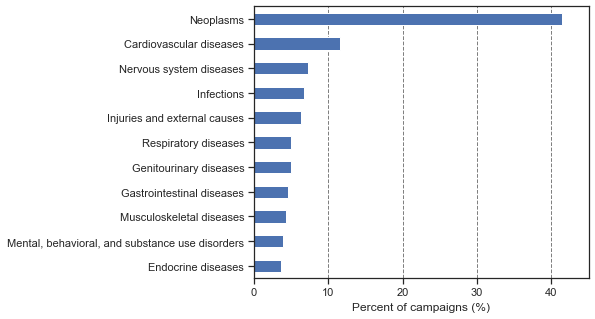

In [323]:
barplot_data = disease_cat_melt['variable'].value_counts(normalize=True).sort_values(ascending=True) * 100
plt.figure(figsize=(6, 5))
ax = barplot_data.plot(kind='barh')
ax.set_xlabel('Percent of campaigns (%)')
ax.set_title('')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_axisbelow(True)
plt.xticks(np.arange(0, 45, 10))
ax.set_xlim([0, 45])
plt.savefig("../plots/any_disease_category_freq.eps", bbox_inches='tight')

#### Supp figure 1 - Primary disease category

In [147]:
fp('primary_disease_cat')

,freq,percent
Neoplasms,34478,53.608023
Cardiovascular diseases,7331,11.398585
Nervous system diseases,3637,5.654979
Injuries and external causes,3580,5.566353
Infections,2830,4.400218
Genitourinary diseases,2662,4.139003
Gastrointestinal diseases,2298,3.573039
Respiratory diseases,2099,3.263624
Musculoskeletal diseases,1949,3.030397
"Mental, behavioral, and substance use disorders",1824,2.836041


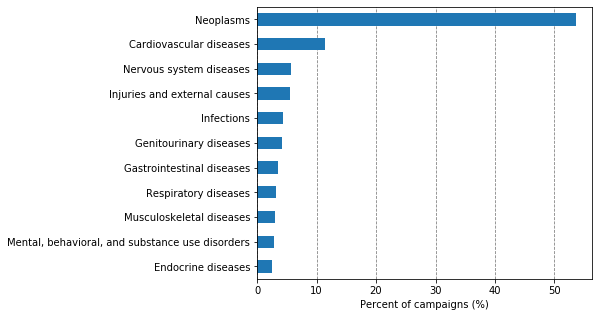

In [149]:
barplot_data = master['primary_disease_cat'].value_counts(normalize=True).sort_values(ascending=True) * 100
plt.figure(figsize=(6, 5))
ax = barplot_data.plot(kind='barh')
ax.set_xlabel('Percent of campaigns (%)')
#ax.set_title('Primary disease category frequency')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_axisbelow(True)
plt.savefig("../plots/primary_disease_category_freq.eps", bbox_inches='tight')

#### Supp figure 2 - Any condition

In [165]:
condition_cat_map = {
    'c_other_neoplasms':'Other neoplasms',
    'c_infections':'Infections',
    'c_hematologic_malignancies':'Hematologic malignancies',
    'c_injuries_and_external_causes':'Injuries and external causes',
    'c_breast_cancer':'Breast cancer',
    'c_other_neurologic_disorders':'Other neurologic disorders',
    'c_other_cardiovascular_disorders':'Other cardiovascular disorders',
    'c_cerebrovascular_diseas':'Cerebrovascular disease',
    'c_other_respiratory_disorders':'Other respiratory disorders',
    'c_musculoskeletal_diseases':'Musculoskeletal diseases',
    'c_mental_and_substance_use_disorders':'Mental and substance use disorders',
    'c_ckd_and_renal_failure':'CKD and renal failure',
    'c_other_gastrointestinal_disorders':'Other gastrointestinal disorders',
    'c_other_genitourinary_disorders':'Other genitourinary disorders',
    'c_lung_cancer':'Lung cancer',
    'c_diabetes':'Diabetes',
    'c_other_endocrine_disorders':'Other endocrine disorders',
    'c_liver_diseases':'Liver diseases',
    'c_coronary_artery_disease':'Coronary artery disease',
    'c_neurodegenerative_diseases':'Neurodegenerative diseases',
    'c_colorectal_cancer':'Colorectal cancer',
    'c_congenital_cardiac_defects':'Congenital cardiac defects',
    'c_congenital_neurologic_defects':'Congenital neurologic defects',
    'c_heart_failure':'Heart failure',
    'c_copd':'COPD'
}

In [166]:
int_pivot_sub = int_pivot[int_pivot['url'].isin(master['url'].tolist())]

In [167]:
l = sorted(master[~master['primary_int_cat'].isna()]['primary_int_cat'].unique().tolist())
l.insert(0, 'url')
int_pivot_sub.columns = l

In [168]:
int_cat_melt = int_pivot[int_pivot.columns[1:]].melt()
int_cat_melt = int_cat_melt[int_cat_melt['value'] > 0]
int_cat_melt['variable'].replace(condition_cat_map, inplace=True)

In [169]:
pd.concat([int_cat_melt['variable'].value_counts(),int_cat_melt['variable'].value_counts(normalize=True)], axis=1)

,variable,variable
Other neoplasms,34085,0.327479
Infections,6055,0.058175
Hematologic malignancies,5815,0.055869
Injuries and external causes,5687,0.054639
Breast cancer,5624,0.054034
Other neurologic disorders,5328,0.051190
Other cardiovascular disorders,4756,0.045694
c_cerebrovascular_disease,4710,0.045252
Other respiratory disorders,4307,0.041380
Musculoskeletal diseases,3897,0.037441


In [170]:
int_cat_melt = int_pivot[int_pivot.columns[1:]].melt()
int_cat_melt = int_cat_melt[int_cat_melt['value'] > 0]
pd.concat([int_cat_melt['variable'].value_counts(),int_cat_melt['variable'].value_counts(normalize=True)], axis=1)

,variable,variable
c_other_neoplasms,34085,0.327479
c_infections,6055,0.058175
c_hematologic_malignancies,5815,0.055869
c_injuries_and_external_causes,5687,0.054639
c_breast_cancer,5624,0.054034
c_other_neurologic_disorders,5328,0.051190
c_other_cardiovascular_disorders,4756,0.045694
c_cerebrovascular_disease,4710,0.045252
c_other_respiratory_disorders,4307,0.041380
c_musculoskeletal_diseases,3897,0.037441


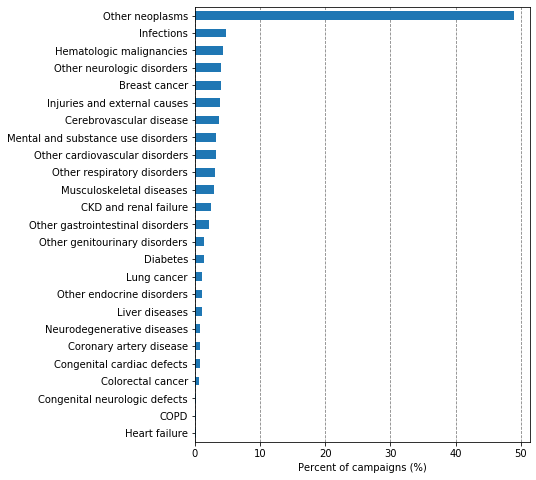

In [173]:
barplot_data = er['int_category'].value_counts(normalize=True).sort_values(ascending=True) * 100
plt.figure(figsize=(6, 8))
ax = barplot_data.plot(kind='barh')
ax.set_xlabel('Percent of campaigns (%)')
#ax.set_title('Condition frequency')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_axisbelow(True)
plt.savefig("../plots/any_condition_freq.eps", bbox_inches='tight')

#### Supp figure 3 - Primary condition

In [172]:
pd.concat([master['primary_int_cat'].value_counts(), master['primary_int_cat'].value_counts(normalize=True)], axis=1)

,primary_int_cat,primary_int_cat
Other neoplasms,27829,0.432698
Injuries and external causes,3613,0.056177
Cerebrovascular disease,3309,0.051450
Hematologic malignancies,3029,0.047096
Infections,2903,0.045137
Other neurologic disorders,2799,0.043520
Other cardiovascular disorders,2542,0.039524
Breast cancer,2414,0.037534
Other respiratory disorders,2044,0.031781
Musculoskeletal diseases,1995,0.031019


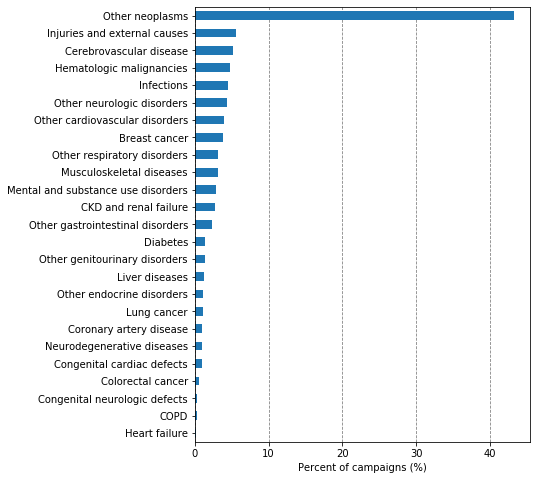

In [175]:
barplot_data = master['primary_int_cat'].value_counts(normalize=True).sort_values(ascending=True) * 100
plt.figure(figsize=(6, 8))
ax = barplot_data.plot(kind='barh')
ax.set_xlabel('Percent of campaigns (%)')
#ax.set_title('Primary condition frequency')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_axisbelow(True)
plt.savefig("../plots/primary_condition_freq.eps", bbox_inches='tight')

#### Disease and condition frequencies in same chart

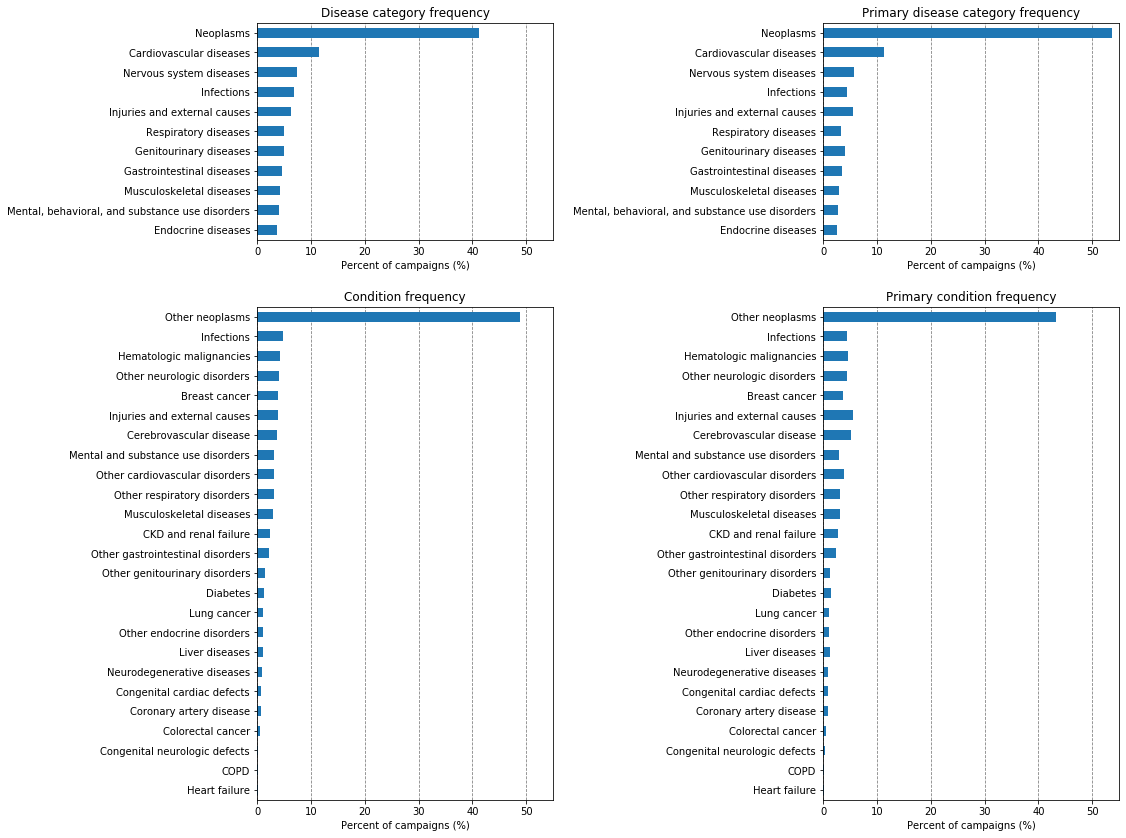

In [128]:
fig, axes = plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[1,1], 'height_ratios':[11,25]}, figsize=(16,12))

barplot_data = disease_cat_melt['variable'].value_counts(normalize=True).sort_values(ascending=True) * 100
barplot_data.plot(kind='barh', ax=axes[0,0])
axes[0,0].set_xlabel('Percent of campaigns (%)')
axes[0,0].set_title('Disease category frequency')
axes[0,0].xaxis.grid(color='gray', linestyle='dashed')
axes[0,0].set_axisbelow(True)
plt.xticks(np.arange(0, 55, 10))
axes[0,0].set_xlim([0, 55])

dz_order = barplot_data.index.tolist()

barplot_data = master['primary_disease_cat'].value_counts(normalize=True).sort_values(ascending=True) * 100
barplot_data = barplot_data.reindex(index=dz_order)
barplot_data.plot(kind='barh', ax=axes[0,1])
axes[0,1].set_xlabel('Percent of campaigns (%)')
axes[0,1].set_title('Primary disease category frequency')
axes[0,1].xaxis.grid(color='gray', linestyle='dashed')
axes[0,1].set_axisbelow(True)
plt.xticks(np.arange(0, 55, 10))
axes[0,1].set_xlim([0, 55])


barplot_data = er['int_category'].value_counts(normalize=True).sort_values(ascending=True) * 100
barplot_data.plot(kind='barh', ax=axes[1,0])
axes[1,0].set_xlabel('Percent of campaigns (%)')
axes[1,0].set_title('Condition frequency')
axes[1,0].xaxis.grid(color='gray', linestyle='dashed')
axes[1,0].set_axisbelow(True)
plt.xticks(np.arange(0, 55, 10))
axes[1,0].set_xlim([0, 55])

cond_order = barplot_data.index.tolist()

barplot_data = master['primary_int_cat'].value_counts(normalize=True).sort_values(ascending=True) * 100
barplot_data = barplot_data.reindex(index=cond_order)
barplot_data.plot(kind='barh', ax=axes[1,1])
axes[1,1].set_xlabel('Percent of campaigns (%)')
axes[1,1].set_title('Primary condition frequency')
axes[1,1].xaxis.grid(color='gray', linestyle='dashed')
axes[1,1].set_axisbelow(True)
plt.xticks(np.arange(0, 55, 10))
axes[1,1].set_xlim([0, 55])

fig.tight_layout(pad=2)

fig.savefig('../plots/all_disease_freq.eps')

#### Primary condition grouped by parent disease category

In [151]:
df = er['int_category'].value_counts(normalize=True).reset_index()
df.columns = ['int_category','count']
df = df.merge(er[['int_category','disease_category']].drop_duplicates('int_category'), on='int_category', how='left')

In [152]:
df = df.sort_values(['disease_category','count'], ascending=[True, False])

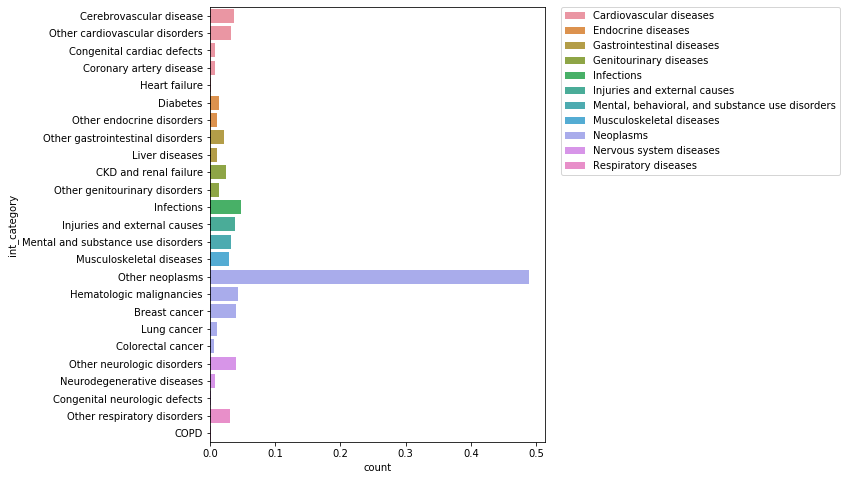

In [153]:
fig, ax = plt.subplots(figsize=(6,8))


sns.barplot(y='int_category', x="count", data=df, ax=ax, hue='disease_category', dodge=False)

#plt.yticks(y_pos)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Supp figure 4 - diseases over time

In [176]:
primary_disease_time = pd.crosstab(master['primary_disease_cat'], master['year'])
primary_disease_time = primary_disease_time.apply(lambda r: r/r.sum(), axis=0).round(3) * 100
primary_disease_time = primary_disease_time.reset_index()
primary_disease_time = pd.melt(primary_disease_time, id_vars=['primary_disease_cat'], 
                               value_vars=["2010","2011","2012",'2013','2014','2015','2016','2017','2018','2019','2020']) 

In [202]:
any_disease_year_wide = master[master.columns[(master.columns.str.startswith('d_'))|(master.columns.str.startswith('year'))]]
any_disease_year_long = pd.melt(any_disease_year_wide, id_vars=['year'])
any_disease_year_long = any_disease_year_long[any_disease_year_long['value'] == 1]
any_disease_year_long['variable'].replace(disease_cat_map, inplace=True)

any_disease_time = pd.crosstab(any_disease_year_long['variable'],any_disease_year_long['year'])
any_disease_time = any_disease_time.apply(lambda r: r/r.sum(), axis=0).round(3) * 100
any_disease_time = any_disease_time.reset_index()
any_disease_time = pd.melt(any_disease_time, id_vars=['variable'], 
                           value_vars=["2010","2011","2012",'2013','2014','2015','2016','2017','2018','2019','2020']) 
any_disease_time.columns = ['any_disease_cat','year','value']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


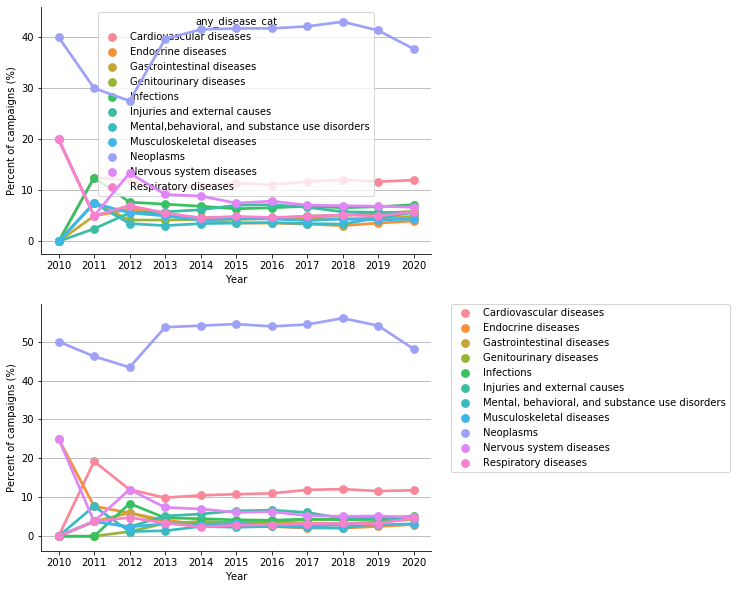

In [207]:
# #time = time[time['primary_cat'] == 'Cardiovascular diseases']
# sns.pointplot(x='year',y='value',hue='primary_disease_cat',data=time)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlabel('Year')
# plt.ylabel('Percent of campaigns')
# plt.savefig("../plots/primary_disease_time_freq.eps", bbox_inches='tight')



fig, axes = plt.subplots(2,1,figsize=(7,10))

sns.pointplot(x='year', y='value', hue='any_disease_cat', data=any_disease_time, join=True, scale=1, ax=axes[0])
axes[0].set_ylabel('Percent of campaigns (%)')
axes[0].set_xlabel('Year')
axes[0].yaxis.grid(True)
sns.despine()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


sns.pointplot(x='year', y='value', hue='primary_disease_cat', data=primary_disease_time, join=True, scale=1, ax=axes[1])
axes[1].set_ylabel('Percent of campaigns (%)')
axes[1].set_xlabel('Year')
axes[1].yaxis.grid(True)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig("../plots/disease_by_year.eps", bbox_inches='tight')

### Figure 2

#### Finances by primary disease cateogry

In [294]:
master['hit_goal'].sum()

14224

Hit goal by primary disease category

In [295]:
hit_goal_df = pd.crosstab(master['hit_goal'],master['primary_disease_cat']).T

In [296]:
hit_goal_df.columns.name = ''

In [297]:
hit_goal_df['sum'] = hit_goal_df.apply(lambda x: x.sum(), axis=1)
hit_goal_df['per'] = (hit_goal_df[1]/hit_goal_df['sum']) * 100
hit_goal_df = hit_goal_df.reset_index()
hit_goal_df

,primary_disease_cat,0,1,sum,per
0,Cardiovascular diseases,6156,1081,7237,14.937129
1,Endocrine diseases,1353,230,1583,14.529375
2,Gastrointestinal diseases,1946,314,2260,13.893805
3,Genitourinary diseases,2276,345,2621,13.162915
4,Infections,2374,409,2783,14.696371
5,Injuries and external causes,3002,524,3526,14.861032
6,"Mental, behavioral, and substance use disorders",1409,314,1723,18.224028
7,Musculoskeletal diseases,1586,313,1899,16.482359
8,Neoplasms,28891,5271,34162,15.429425
9,Nervous system diseases,2911,666,3577,18.618954


In [412]:
master['primary_disease_cat'] = master['primary_disease_cat'].fillna('No disease')

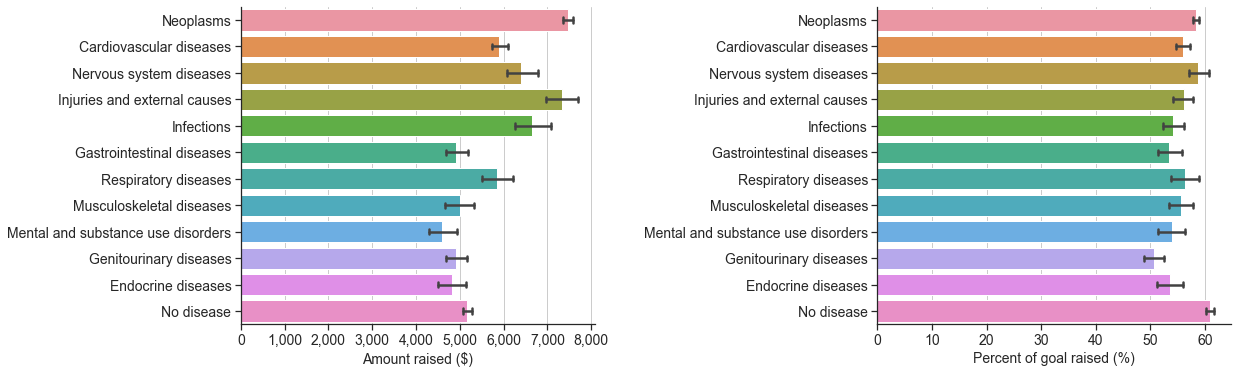

In [413]:

master.replace({'Mental, behavioral, and substance use disorders':'Mental and substance use disorders'}, inplace=True)

order = ['Neoplasms',
         'Cardiovascular diseases',
         'Nervous system diseases',
         'Injuries and external causes',
         'Infections',
         'Gastrointestinal diseases',
         'Respiratory diseases',
         'Musculoskeletal diseases',
         'Mental and substance use disorders',
         'Genitourinary diseases',
         'Endocrine diseases',
        'No disease']


import matplotlib


fig, axes = plt.subplots(1, 2, figsize=(18,6))


sns.set(style="ticks")
sns.barplot(data=master, y='primary_disease_cat', x='current_amount', order=order, ax=axes[0], capsize=0.2, errwidth=2.5)
axes[0].set_yticklabels(axes[0].get_yticklabels(), size=14)
axes[0].set_xticklabels(axes[0].get_xticks().astype(int), size=14)
axes[0].set_ylabel('')
axes[0].set_xlabel('Amount raised ($)', size=14)
axes[0].xaxis.grid(True)
axes[0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()


sns.set(style="ticks")
sns.barplot(data=master, y='primary_disease_cat', x='per_raised_winsor_1', order=order, ax=axes[1], capsize=0.2, errwidth=2.5)
axes[1].set_yticklabels(axes[1].get_yticklabels(), size=14)
axes[1].set_xticklabels(axes[1].get_xticks().astype(int), size=14)
axes[1].set_ylabel('')
axes[1].set_xlabel('Percent of goal raised (%)', size=14)
axes[1].xaxis.grid(True)
sns.despine()


fig.tight_layout(pad=3)

#fig.savefig('../plots/figure_2.eps')

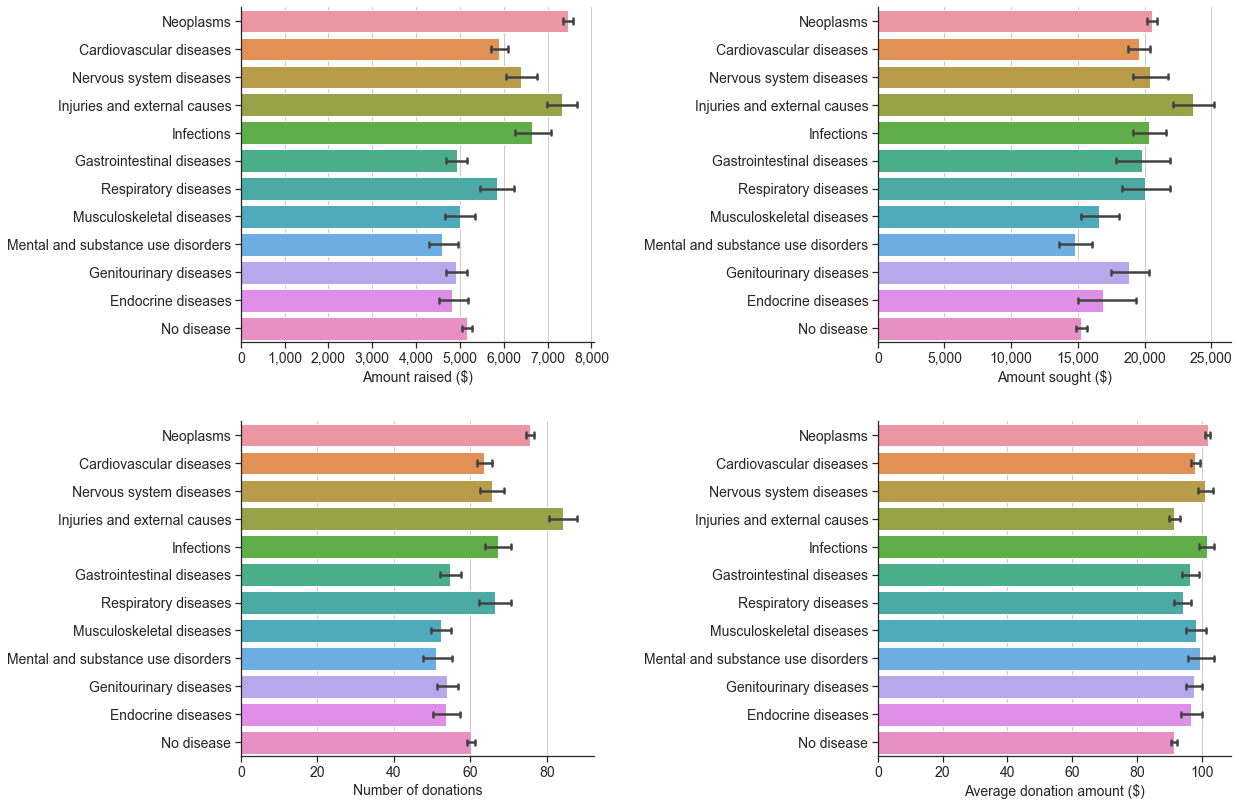

In [414]:
# master.replace({'Mental, behavioral, and substance use disorders':'Mental and substance use disorders'}, inplace=True)

# order = ['Neoplasms','Cardiovascular diseases','Nervous system diseases','Injuries and external causes', 'Infections','Gastrointestinal diseases','Respiratory diseases','Musculoskeletal diseases','Mental and substance use disorders','Genitourinary diseases','Endocrine diseases']

# import string

# fig, axes = plt.subplots(3, 2, figsize=(15,17))

# pal = sns.color_palette()

# sns.set(style="ticks")
# sns.pointplot(data=master, y='primary_disease_cat',x='current_amount_winsor_25', join=False, capsize=0.15, order=order, ax=axes[0,0], scale=1, errwidth=2)
# #axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), rotation=30, ha="right", size=14)
# axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), size=14)
# axes[0,0].set_ylabel('')
# axes[0,0].set_xlabel('Current amount ($)', size=14)
# axes[0,0].xaxis.grid(True)
# #axes[0,0].get_legend().remove()
# sns.despine()

# sns.set(style="ticks")
# sns.pointplot(data=master, y='primary_disease_cat', x='goal_amount_winsor_25', join=False, capsize=0.15, order=order, ax=axes[0,1], scale=1, errwidth=2)
# axes[0,1].set_yticklabels(axes[0,1].get_yticklabels(), size=14)
# axes[0,1].set_ylabel('')
# axes[0,1].set_xlabel('Goal amount ($)', size=14)
# axes[0,1].xaxis.grid(True)
# #axes[0,1].get_legend().remove()
# sns.despine()

# sns.set(style="ticks")
# sns.pointplot(data=master, y='primary_disease_cat', x='donation_amount_winsor_25', join=False, capsize=0.15, order=order, ax=axes[1,0], scale=1, errwidth=2)
# axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), size=14)
# axes[1,0].set_ylabel('')
# axes[1,0].set_xlabel('Average donation amount ($)', size=14)
# axes[1,0].xaxis.grid(True)
# #axes[1,0].get_legend().remove()
# sns.despine()

# sns.set(style="ticks")
# sns.pointplot(data=master, y='primary_disease_cat', x='donation_count_winsor_25', join=False, capsize=0.15, order=order, ax=axes[1,1], scale=1, errwidth=2)
# axes[1,1].set_yticklabels(axes[1,1].get_yticklabels(), size=14)
# axes[1,1].set_ylabel('')
# axes[1,1].set_xlabel('Donation count', size=14)
# axes[1,1].xaxis.grid(True)
# #axes[1,1].get_legend().remove()
# sns.despine()

# sns.set(style="ticks")
# sns.pointplot(data=master, y='primary_disease_cat', x='per_raised_winsor_25', join=False, capsize=0.15, order=order, ax=axes[2,0], scale=1, errwidth=2)
# axes[2,0].set_yticklabels(axes[2,0].get_yticklabels(), size=14)
# #axes[1,1].set_yticklabels(axes[1,1].get_yticklabels(), size=14)
# axes[2,0].set_ylabel('')
# axes[2,0].set_xlabel('Percent of goal raised (%)', size=14)
# axes[2,0].xaxis.grid(True)
# #axes[1,1].get_legend().remove()
# sns.despine()

# sns.set(style="ticks")
# sns.barplot(data=hit_goal_df, y='primary_disease_cat', x='per', order=order, ax=axes[2,1], color='#1f77b4')
# axes[2,1].set_yticklabels(axes[2,1].get_yticklabels(),size=14)
# axes[2,1].set_ylabel('')
# axes[2,1].set_xlabel('Percent of campaigns that reached goal (%)', size=14)
# axes[2,1].xaxis.grid(True, zorder=0)
# #axes[2,1].get_legend().remove()
# sns.despine()






# master.replace({'Mental, behavioral, and substance use disorders':'Mental and substance use disorders'}, inplace=True)

# order = ['Neoplasms','Cardiovascular diseases','Nervous system diseases','Injuries and external causes', 'Infections','Gastrointestinal diseases','Respiratory diseases','Musculoskeletal diseases','Mental and substance use disorders','Genitourinary diseases','Endocrine diseases']


# fig, axes = plt.subplots(1, 2, figsize=(18,6))


# sns.set(style="ticks")
# sns.boxplot(data=master, y='primary_disease_cat', x='current_amount_winsor_25', order=order, ax=axes[0], showfliers=False, whis=0)
# axes[0].set_yticklabels(axes[0].get_yticklabels(), size=14)
# axes[0].set_xticklabels(axes[0].get_xticks().astype(int), size=14)
# axes[0].set_ylabel('')
# axes[0].set_xlabel('Amount raised ($)', size=14)
# axes[0].xaxis.grid(True)
# axes[0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# sns.despine()


# sns.set(style="ticks")
# sns.boxplot(data=master, y='primary_disease_cat', x='per_raised_winsor_25', order=order, ax=axes[1], showfliers=False)
# axes[1].set_yticklabels(axes[1].get_yticklabels(), size=14)
# axes[1].set_xticklabels(axes[1].get_xticks().astype(int), size=14)
# axes[1].set_ylabel('')
# axes[1].set_xlabel('Percent of goal raised (%)', size=14)
# axes[1].xaxis.grid(True)
# sns.despine()


# fig.tight_layout(pad=3)

# fig.savefig('../plots/figure_2.eps')






master.replace({'Mental, behavioral, and substance use disorders':'Mental and substance use disorders'}, inplace=True)

order = ['Neoplasms',
         'Cardiovascular diseases',
         'Nervous system diseases',
         'Injuries and external causes',
         'Infections',
         'Gastrointestinal diseases',
         'Respiratory diseases',
         'Musculoskeletal diseases',
         'Mental and substance use disorders',
         'Genitourinary diseases',
         'Endocrine diseases',
        'No disease']

import matplotlib

fig, axes = plt.subplots(2, 2, figsize=(18,12))

for row in axes:
    for ax in row:
        ax.grid(zorder=0)


sns.set(style="ticks")
sns.barplot(data=master, y='primary_disease_cat', x='current_amount', order=order, ax=axes[0,0], capsize=0.2, errwidth=2.5)
axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), size=14)
axes[0,0].set_xticklabels(axes[0,0].get_xticks().astype(int), size=14)
axes[0,0].set_ylabel('')
axes[0,0].set_xlabel('Amount raised ($)', size=14)
axes[0,0].xaxis.grid(True)
axes[0,0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()


sns.set(style="ticks")
sns.barplot(data=master, y='primary_disease_cat', x='goal_amount', order=order, ax=axes[0,1], capsize=0.2, errwidth=2.5)
axes[0,1].set_yticklabels(axes[0,1].get_yticklabels(), size=14)
axes[0,1].set_xticklabels(axes[0,1].get_xticks().astype(int), size=14)
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('Amount sought ($)', size=14)
axes[0,1].xaxis.grid(True)
axes[0,1].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, y='primary_disease_cat', x='donation_count', order=order, ax=axes[1,0], capsize=0.2, errwidth=2.5)
axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), size=14)
axes[1,0].set_xticklabels(axes[1,0].get_xticks().astype(int), size=14)
axes[1,0].set_ylabel('')
axes[1,0].set_xlabel('Number of donations', size=14)
axes[1,0].xaxis.grid(True)
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, y='primary_disease_cat', x='donation_mean',order=order, ax=axes[1,1], capsize=0.2, errwidth=2.5)
axes[1,1].set_yticklabels(axes[1,1].get_yticklabels(), size=14)
axes[1,1].set_xticklabels(axes[1,1].get_xticks().astype(int), size=14)
axes[1,1].set_ylabel('')
axes[1,1].set_xlabel('Average donation amount ($)', size=14)
axes[1,1].xaxis.grid(True)
sns.despine()

# sns.set(style="ticks")
# sns.pointplot(data=master, y='primary_disease_cat', x='per_raised_winsor_25', join=False, capsize=0.15, order=order, ax=axes[2,0], scale=1, errwidth=2)
# axes[2,0].set_yticklabels(axes[2,0].get_yticklabels(), size=14)
# axes[2,0].set_xticklabels(axes[2,0].get_xticks().astype(int), size=14)
# axes[2,0].set_ylabel('')
# axes[2,0].set_xlabel('Percent of amount sought raised (%)', size=14)
# axes[2,0].xaxis.grid(True)
# sns.despine()

# sns.set(style="ticks")
# sns.barplot(data=hit_goal_df, y='primary_disease_cat', x='per', order=order, ax=axes[2,1], color='#1f77b4')
# axes[2,1].set_yticklabels(axes[2,1].get_yticklabels(),size=14)
# axes[2,1].set_xticklabels(axes[2,1].get_xticks().astype(int), size=14)
# axes[2,1].set_ylabel('')
# axes[2,1].set_xlabel('Percent of campaigns that reached goal (%)', size=14)
# axes[2,1].xaxis.grid(True, zorder=0)
# #axes[2,1].get_legend().remove()
# sns.despine()



fig.tight_layout(pad=3)

fig.savefig('../plots/figure_2_full.eps')




#### Finances by any disease category

In [324]:
disease_cat_melt = disease_pivot_sub.melt(id_vars=['url'])

In [327]:
disease_cat_melt['variable'].replace(disease_cat_map, inplace=True)

In [329]:
disease_cat_melt.columns = ['url','cat','present']

In [330]:
a = pd.merge(master, disease_cat_melt, on='url', how='left')

In [333]:
order = ['Neoplasms','Cardiovascular diseases','Nervous system diseases','Injuries and external causes', 'Infections','Gastrointestinal diseases','Respiratory diseases','Musculoskeletal diseases','Mental and substance use disorders','Genitourinary diseases','Endocrine diseases']

In [336]:
a.replace({'Mental, behavioral, and substance use disorders':'Mental and substance use disorders'}, inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


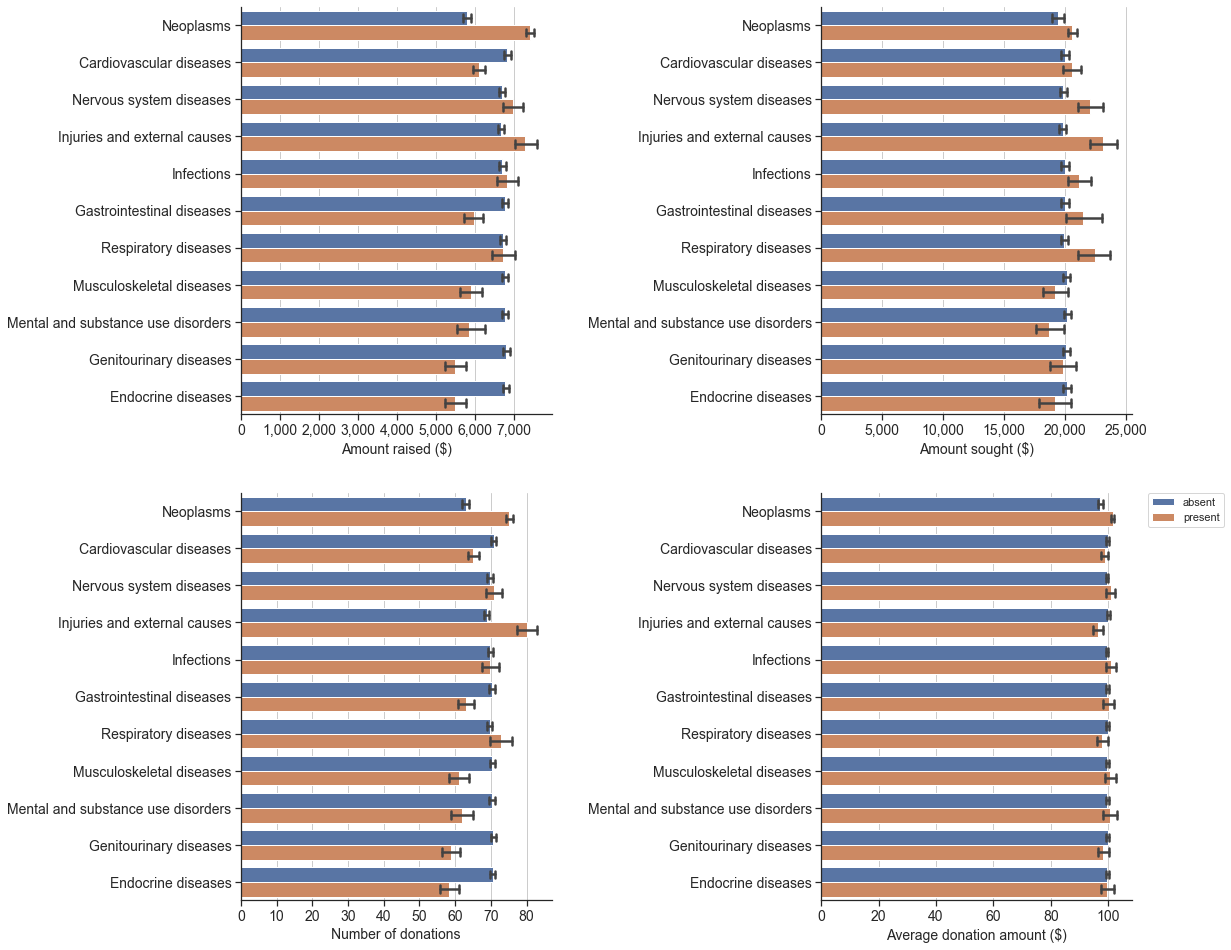

In [353]:
import matplotlib

fig, axes = plt.subplots(2, 2, figsize=(18,14))

for row in axes:
    for ax in row:
        ax.grid(zorder=0)


sns.set(style="ticks")
sns.barplot(y="cat", x="current_amount", hue='present_lab', data=a, order=order, ax=axes[0,0], capsize=0.2, errwidth=2.5)
axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(), size=14)
axes[0,0].set_xticklabels(axes[0,0].get_xticks().astype(int), size=14)
axes[0,0].set_ylabel('')
axes[0,0].set_xlabel('Amount raised ($)', size=14)
axes[0,0].xaxis.grid(True)
axes[0,0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
axes[0,0].get_legend().remove()
sns.despine()


sns.set(style="ticks")
sns.barplot(y="cat", x="goal_amount", hue='present_lab', data=a, order=order, ax=axes[0,1], capsize=0.2, errwidth=2.5)
axes[0,1].set_yticklabels(axes[0,1].get_yticklabels(), size=14)
axes[0,1].set_xticklabels(axes[0,1].get_xticks().astype(int), size=14)
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('Amount sought ($)', size=14)
axes[0,1].xaxis.grid(True)
axes[0,1].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
axes[0,1].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(y="cat", x="donation_count", hue='present_lab', data=a, order=order, ax=axes[1,0], capsize=0.2, errwidth=2.5)
axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), size=14)
axes[1,0].set_xticklabels(axes[1,0].get_xticks().astype(int), size=14)
axes[1,0].set_ylabel('')
axes[1,0].set_xlabel('Number of donations', size=14)
axes[1,0].xaxis.grid(True)
axes[1,0].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(y="cat", x="donation_mean", hue='present_lab', data=a, order=order, ax=axes[1,1], capsize=0.2, errwidth=2.5)
axes[1,1].set_yticklabels(axes[1,1].get_yticklabels(), size=14)
axes[1,1].set_xticklabels(axes[1,1].get_xticks().astype(int), size=14)
axes[1,1].set_ylabel('')
axes[1,1].set_xlabel('Average donation amount ($)', size=14)
axes[1,1].xaxis.grid(True)
#axes[1,1].get_legend().remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

fig.tight_layout(pad=3)

#fig.savefig('../plots/figure_2_present_absent.eps')

### Frequency of disease categories by census region

In [248]:
d_by_region.round(3).astype(str).add(' (').add(d_by_region_per.round(2).astype(str)).add(')')

,Midwest,Northeast,South,West
primary_disease_cat,,,,
Cardiovascular diseases,2.285 (25.0),2.022 (23.0),2.241 (25.0),2.419 (27.0)
Endocrine diseases,0.537 (27.0),0.437 (22.0),0.498 (25.0),0.516 (26.0)
Gastrointestinal diseases,0.658 (24.0),0.56 (20.0),0.759 (28.0),0.771 (28.0)
Genitourinary diseases,0.722 (23.0),0.742 (23.0),0.909 (29.0),0.814 (26.0)
Infections,0.881 (25.0),0.842 (24.0),0.814 (23.0),0.975 (28.0)
Injuries and external causes,1.107 (25.0),0.958 (22.0),1.032 (23.0),1.309 (30.0)
"Mental, behavioral, and substance use disorders",0.554 (25.0),0.525 (23.0),0.508 (23.0),0.668 (30.0)
Musculoskeletal diseases,0.596 (25.0),0.503 (21.0),0.595 (25.0),0.678 (29.0)
Neoplasms,10.566 (25.0),10.192 (24.0),10.034 (24.0),11.854 (28.0)


In [162]:
#rate of crowdfunding campaign for a given diagnosis per population of 100,000
d_by_region['Midwest'] = (d_by_region['Midwest']/pop_by_region['Midwest'])*100000
d_by_region['Northeast'] = (d_by_region['Northeast']/pop_by_region['Northeast'])*100000
d_by_region['South'] = (d_by_region['South']/pop_by_region['South'])*100000
d_by_region['West'] = (d_by_region['West']/pop_by_region['West'])*100000

#percent
d_by_region_per = d_by_region.apply(lambda r: r/r.sum(), axis=1).round(2) * 100

Any disease category

In [206]:
disease_cat_census_melt = disease_pivot.melt(id_vars=['url'])
dz_by_region = pd.merge(master[['url','census_region']],disease_cat_census_melt, on='url', how='left')
dz_by_region = dz_by_region[dz_by_region['value'] > 0]

In [209]:
dz_by_region = pd.crosstab(dz_by_region['variable'], dz_by_region['census_region'])

dz_by_region['Midwest'] = (dz_by_region['Midwest']/pop_by_region['Midwest'])*100000
dz_by_region['Northeast'] = (dz_by_region['Northeast']/pop_by_region['Northeast'])*100000
dz_by_region['South'] = (dz_by_region['South']/pop_by_region['South'])*100000
dz_by_region['West'] = (dz_by_region['West']/pop_by_region['West'])*100000

#percent
dz_by_region_per = dz_by_region.apply(lambda r: r/r.sum(), axis=1).round(2) * 100

In [247]:
dz_by_region.round(3).astype(str).add(' (').add(dz_by_region_per.round(2).astype(str)).add(')')

census_region,Midwest,Northeast,South,West
variable,,,,
Cardiovascular diseases,3.321 (26.0),2.864 (23.0),3.108 (25.0),3.294 (26.0)
Endocrine diseases,1.042 (26.0),0.892 (23.0),0.994 (25.0),1.008 (26.0)
Gastrointestinal diseases,1.229 (24.0),1.055 (21.0),1.291 (26.0),1.444 (29.0)
Genitourinary diseases,1.229 (23.0),1.206 (23.0),1.468 (28.0),1.39 (26.0)
Infections,1.884 (25.0),1.765 (24.0),1.745 (23.0),2.048 (28.0)
Injuries and external causes,1.778 (26.0),1.487 (21.0),1.641 (24.0),2.036 (29.0)
"Mental, behavioral, and substance use disorders",1.125 (25.0),1.048 (24.0),0.984 (22.0),1.299 (29.0)
Musculoskeletal diseases,1.201 (25.0),1.053 (22.0),1.135 (24.0),1.348 (28.0)
Neoplasms,11.284 (25.0),10.778 (24.0),10.656 (24.0),12.565 (28.0)


Primary condition

In [211]:
c_by_region = pd.crosstab(master['primary_int_cat'],master['census_region'])
c_by_region.columns.name = ''

In [212]:
#rate of crowdfunding campaign for a given diagnosis per population of 100,000
c_by_region['Midwest'] = (c_by_region['Midwest']/pop_by_region['Midwest'])*100000
c_by_region['Northeast'] = (c_by_region['Northeast']/pop_by_region['Northeast'])*100000
c_by_region['South'] = (c_by_region['South']/pop_by_region['South'])*100000
c_by_region['West'] = (c_by_region['West']/pop_by_region['West'])*100000

#percent
c_by_region_per = c_by_region.apply(lambda r: r/r.sum(), axis=1).round(2) * 100

In [246]:
c_by_region.round(3).astype(str).add(' (').add(c_by_region_per.round(2).astype(str)).add(')')

,Midwest,Northeast,South,West
primary_int_cat,,,,
Breast cancer,0.646 (22.0),0.71 (24.0),0.771 (26.0),0.805 (27.0)
CKD and renal failure,0.499 (23.0),0.498 (23.0),0.603 (28.0),0.535 (25.0)
COPD,0.059 (31.0),0.048 (26.0),0.041 (22.0),0.039 (21.0)
Cerebrovascular disease,0.987 (24.0),0.974 (24.0),1.03 (25.0),1.054 (26.0)
Colorectal cancer,0.123 (29.0),0.102 (24.0),0.106 (25.0),0.088 (21.0)
Congenital cardiac defects,0.197 (27.0),0.171 (23.0),0.185 (25.0),0.179 (24.0)
Congenital neurologic defects,0.072 (33.0),0.052 (23.0),0.052 (23.0),0.045 (21.0)
Coronary artery disease,0.258 (32.0),0.141 (18.0),0.184 (23.0),0.214 (27.0)
Diabetes,0.301 (28.0),0.203 (19.0),0.281 (26.0),0.307 (28.0)


Any condition

In [214]:
int_cat_census_melt = int_pivot.melt(id_vars=['url'])
co_by_region = pd.merge(master[['url','census_region']],int_cat_census_melt, on='url', how='left')
co_by_region = co_by_region[co_by_region['value'] > 0]

In [215]:
co_by_region = pd.crosstab(co_by_region['variable'], co_by_region['census_region'])

co_by_region['Midwest'] = (co_by_region['Midwest']/pop_by_region['Midwest'])*100000
co_by_region['Northeast'] = (co_by_region['Northeast']/pop_by_region['Northeast'])*100000
co_by_region['South'] = (co_by_region['South']/pop_by_region['South'])*100000
co_by_region['West'] = (co_by_region['West']/pop_by_region['West'])*100000

#percent
co_by_region_per = co_by_region.apply(lambda r: r/r.sum(), axis=1).round(2) * 100

In [244]:
co_by_region.round(3).astype(str).add(' (').add(co_by_region_per.round(2).astype(str)).add(')')

census_region,Midwest,Northeast,South,West
variable,,,,
Breast cancer,1.639 (24.0),1.628 (24.0),1.66 (24.0),1.956 (28.0)
CKD and renal failure,0.865 (23.0),0.873 (24.0),1.045 (28.0),0.928 (25.0)
COPD,0.107 (27.0),0.102 (26.0),0.092 (24.0),0.091 (23.0)
Cerebrovascular disease,1.43 (25.0),1.351 (24.0),1.433 (25.0),1.526 (27.0)
Colorectal cancer,0.352 (27.0),0.334 (25.0),0.303 (23.0),0.333 (25.0)
Congenital cardiac defects,0.322 (28.0),0.248 (21.0),0.289 (25.0),0.303 (26.0)
Congenital neurologic defects,0.15 (32.0),0.109 (23.0),0.105 (23.0),0.104 (22.0)
Coronary artery disease,0.551 (35.0),0.328 (21.0),0.34 (21.0),0.366 (23.0)
Diabetes,0.536 (25.0),0.43 (20.0),0.574 (27.0),0.576 (27.0)


### Distribution of financial variables

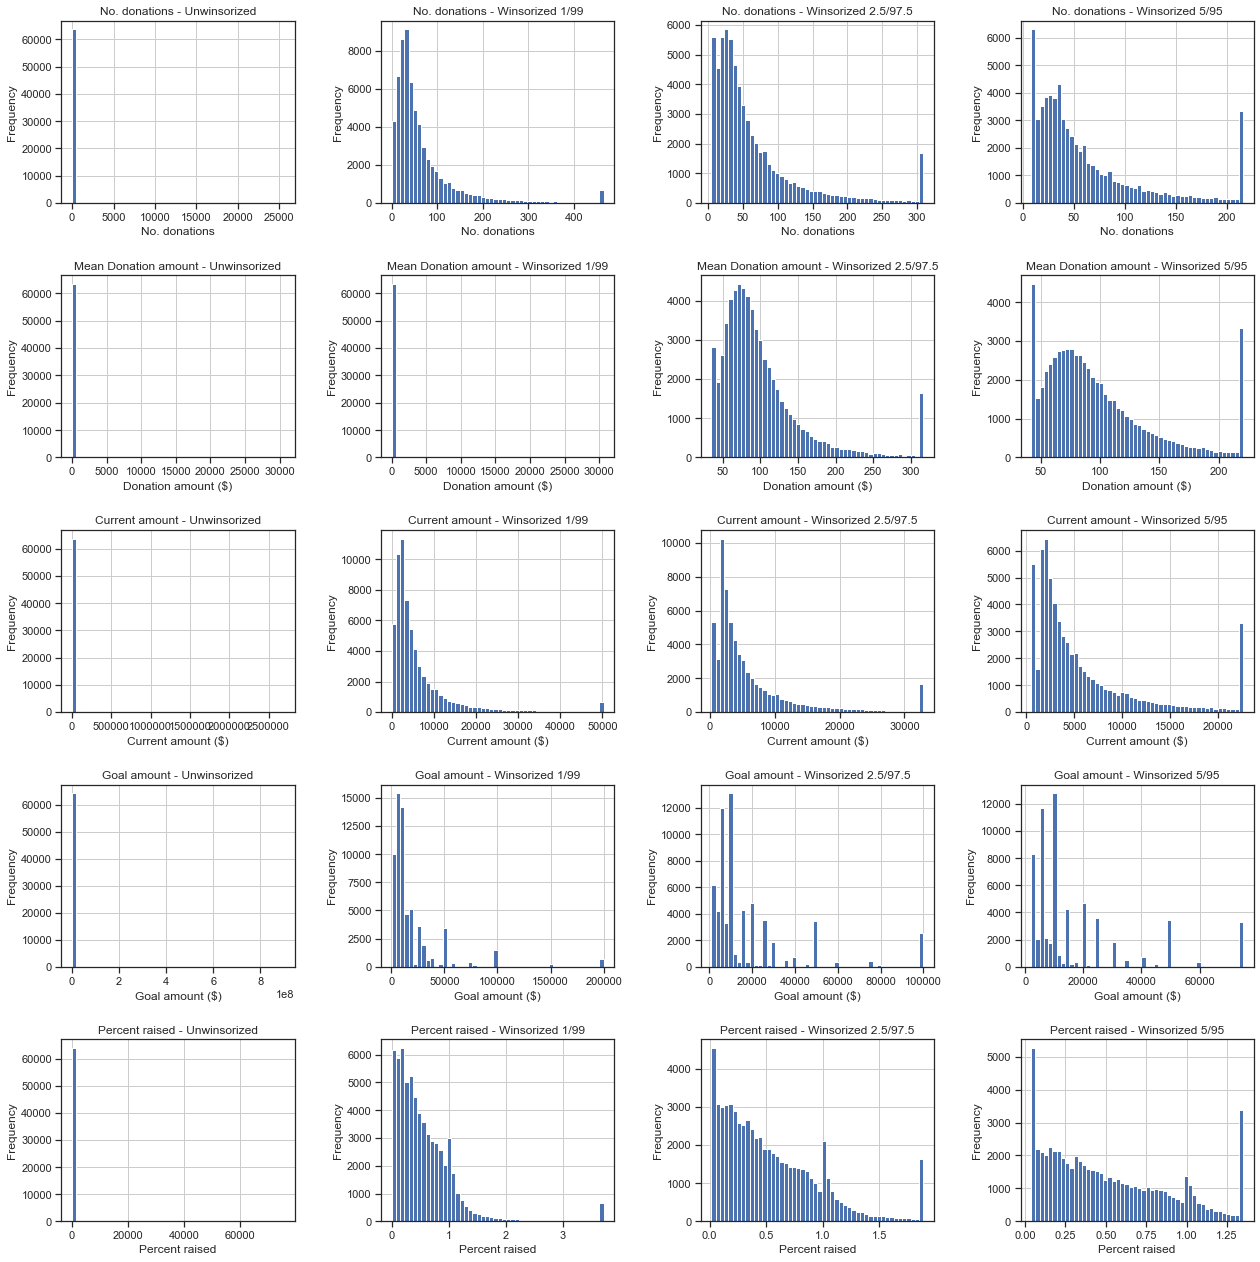

In [223]:
fig, axes = plt.subplots(5, 4, figsize=(18,18))

for row in axes:
    for ax in row:
        ax.grid(zorder=0)

master['donation_count'].hist(bins=50, ax=axes[0,0])
axes[0,0].set_title('No. donations - Unwinsorized')
axes[0,0].set_xlabel("No. donations")
axes[0,0].set_ylabel("Frequency")

master['donation_count_winsor_1'].hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('No. donations - Winsorized 1/99')
axes[0,1].set_xlabel("No. donations")
axes[0,1].set_ylabel("Frequency")

master['donation_count_winsor_25'].hist(bins=50, ax=axes[0,2])
axes[0,2].set_title('No. donations - Winsorized 2.5/97.5')
axes[0,2].set_xlabel("No. donations")
axes[0,2].set_ylabel("Frequency")

master['donation_count_winsor_5'].hist(bins=50, ax=axes[0,3])
axes[0,3].set_title('No. donations - Winsorized 5/95')
axes[0,3].set_xlabel("No. donations")
axes[0,3].set_ylabel("Frequency")

master['don_mean'].hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Mean Donation amount - Unwinsorized')
axes[1,0].set_xlabel("Donation amount ($)")
axes[1,0].set_ylabel("Frequency")

master['donation_amount_winsor_1'].hist(bins=50, ax=axes[1,1])
axes[1,1].set_title('Mean Donation amount - Winsorized 1/99')
axes[1,1].set_xlabel("Donation amount ($)")
axes[1,1].set_ylabel("Frequency")

master['donation_amount_winsor_25'].hist(bins=50, ax=axes[1,2])
axes[1,2].set_title('Mean Donation amount - Winsorized 2.5/97.5')
axes[1,2].set_xlabel("Donation amount ($)")
axes[1,2].set_ylabel("Frequency")

master['donation_amount_winsor_5'].hist(bins=50, ax=axes[1,3])
axes[1,3].set_title('Mean Donation amount - Winsorized 5/95')
axes[1,3].set_xlabel("Donation amount ($)")
axes[1,3].set_ylabel("Frequency")

master['current_amount'].hist(bins=50, ax=axes[2,0])
axes[2,0].set_title('Current amount - Unwinsorized')
axes[2,0].set_xlabel("Current amount ($)")
axes[2,0].set_ylabel("Frequency")

master['current_amount_winsor_1'].hist(bins=50, ax=axes[2,1])
axes[2,1].set_title('Current amount - Winsorized 1/99')
axes[2,1].set_xlabel("Current amount ($)")
axes[2,1].set_ylabel("Frequency")

master['current_amount_winsor_25'].hist(bins=50, ax=axes[2,2])
axes[2,2].set_title('Current amount - Winsorized 2.5/97.5')
axes[2,2].set_xlabel("Current amount ($)")
axes[2,2].set_ylabel("Frequency")

master['current_amount_winsor_5'].hist(bins=50, ax=axes[2,3])
axes[2,3].set_title('Current amount - Winsorized 5/95')
axes[2,3].set_xlabel("Current amount ($)")
axes[2,3].set_ylabel("Frequency")

master['goal_amount'].hist(bins=50, ax=axes[3,0])
axes[3,0].set_title('Goal amount - Unwinsorized')
axes[3,0].set_xlabel("Goal amount ($)")
axes[3,0].set_ylabel("Frequency")

master['goal_amount_winsor_1'].hist(bins=50, ax=axes[3,1])
axes[3,1].set_title('Goal amount - Winsorized 1/99')
axes[3,1].set_xlabel("Goal amount ($)")
axes[3,1].set_ylabel("Frequency")

master['goal_amount_winsor_25'].hist(bins=50, ax=axes[3,2])
axes[3,2].set_title('Goal amount - Winsorized 2.5/97.5')
axes[3,2].set_xlabel("Goal amount ($)")
axes[3,2].set_ylabel("Frequency")

master['goal_amount_winsor_5'].hist(bins=50, ax=axes[3,3])
axes[3,3].set_title('Goal amount - Winsorized 5/95')
axes[3,3].set_xlabel("Goal amount ($)")
axes[3,3].set_ylabel("Frequency")

master['per_raised'].hist(bins=50, ax=axes[4,0])
axes[4,0].set_title('Percent raised - Unwinsorized')
axes[4,0].set_xlabel("Percent raised")
axes[4,0].set_ylabel("Frequency")

master['per_raised_winsor_1'].hist(bins=50, ax=axes[4,1])
axes[4,1].set_title('Percent raised - Winsorized 1/99')
axes[4,1].set_xlabel("Percent raised")
axes[4,1].set_ylabel("Frequency")

master['per_raised_winsor_25'].hist(bins=50, ax=axes[4,2])
axes[4,2].set_title('Percent raised - Winsorized 2.5/97.5')
axes[4,2].set_xlabel("Percent raised")
axes[4,2].set_ylabel("Frequency")

master['per_raised_winsor_5'].hist(bins=50, ax=axes[4,3])
axes[4,3].set_title('Percent raised - Winsorized 5/95')
axes[4,3].set_xlabel("Percent raised")
axes[4,3].set_ylabel("Frequency")


fig.tight_layout(pad=2)

fig.savefig('../plots/finance_distributions.eps')

### Figure 3

#### Finances by census region

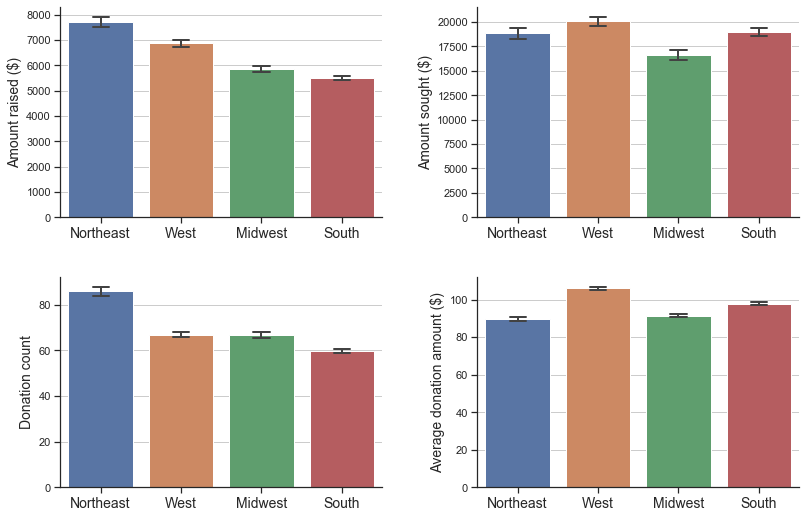

In [388]:
order = ['Northeast','West','Midwest','South']


fig, axes = plt.subplots(2, 2, figsize=(12,8))

for row in axes:
    for ax in row:
        ax.grid(zorder=0)

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='current_amount', order=order, ax=axes[0,0], capsize=0.2, errwidth=2)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), size=14)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Amount raised ($)', size=14)
axes[0,0].yaxis.grid(True)
#axes[0,0].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='goal_amount', order=order, ax=axes[0,1], capsize=0.2, errwidth=2)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), size=14)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Amount sought ($)', size=14)
axes[0,1].yaxis.grid(True)
#axes[0,1].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='donation_count', order=order, ax=axes[1,0], capsize=0.2, errwidth=2)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), size=14)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Donation count', size=14)
axes[1,0].yaxis.grid(True)
#axes[1,0].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='donation_mean', order=order, ax=axes[1,1], capsize=0.2, errwidth=2)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), size=14)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Average donation amount ($)', size=14)
axes[1,1].yaxis.grid(True)
#axes[1,1].get_legend().remove()
sns.despine()


# sns.set(style="ticks")
# sns.pointplot(data=master, x='census_region', y='per_raised_winsor_25', join=False, capsize=0.15, order=order, ax=axes[2,0], scale=1, errwidth=2, hue='census_region')
# axes[2,0].set_xticklabels(axes[2,0].get_xticklabels(), size=14)
# axes[2,0].set_xlabel('')
# axes[2,0].set_ylabel('Percent of goal raised (%)', size=14)
# axes[2,0].yaxis.grid(True)
# axes[2,0].get_legend().remove()
# sns.despine()

# northeast = ['Northeast' for x in range(0,20)]
# midwest = ['Midwest' for x in range(0,17)]
# south = ['South' for x in range (0,14)]
# west = ['West' for x in range(0,16)]

# together = northeast + midwest + south + west

# hit_goal = pd.DataFrame({'census_region':together})

# pal = []
# pal.append(sns.color_palette()[0])
# pal.append(sns.color_palette()[2])
# pal.append(sns.color_palette()[3])
# pal.append(sns.color_palette()[1])


# sns.set(style="ticks")
# sns.countplot(data=hit_goal, x='census_region', order=order, ax=axes[2,1], palette=pal)
# axes[2,1].set_xticklabels(axes[1,1].get_xticklabels(), size=14)
# axes[2,1].set_xlabel('')
# axes[2,1].set_ylabel('Reached fundraising goal (%)', size=14)
# axes[2,1].yaxis.grid(True, zorder=0)
# #axes[2,1].get_legend().remove()
# sns.despine()

fig.tight_layout(pad=3)

fig.savefig('../plots/figure_3_no_cdi.eps')


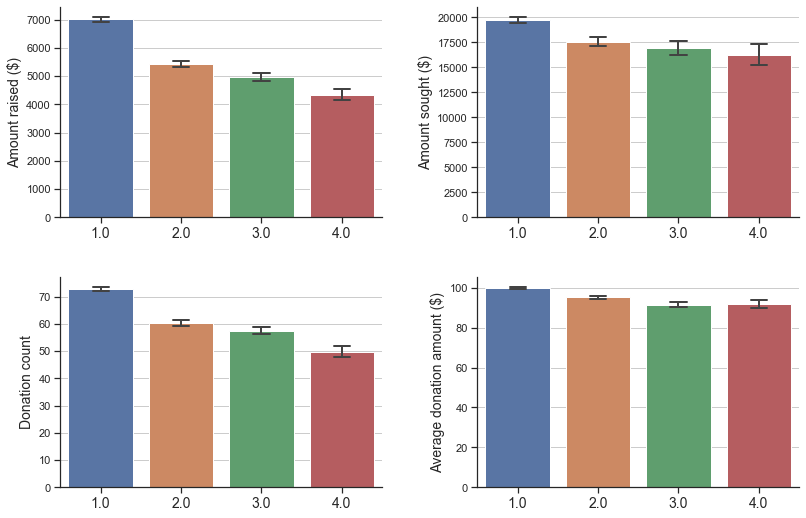

In [389]:
#order = ['Northeast','West','Midwest','South']


fig, axes = plt.subplots(2, 2, figsize=(12,8))

for row in axes:
    for ax in row:
        ax.grid(zorder=0)

sns.set(style="ticks")
sns.barplot(data=master, x='ndi_quantile', y='current_amount', ax=axes[0,0], capsize=0.2, errwidth=2)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), size=14)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Amount raised ($)', size=14)
axes[0,0].yaxis.grid(True)
#axes[0,0].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='ndi_quantile', y='goal_amount', ax=axes[0,1], capsize=0.2, errwidth=2)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), size=14)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Amount sought ($)', size=14)
axes[0,1].yaxis.grid(True)
#axes[0,1].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='ndi_quantile', y='donation_count', ax=axes[1,0], capsize=0.2, errwidth=2)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), size=14)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Donation count', size=14)
axes[1,0].yaxis.grid(True)
#axes[1,0].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='ndi_quantile', y='donation_mean', ax=axes[1,1], capsize=0.2, errwidth=2)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), size=14)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Average donation amount ($)', size=14)
axes[1,1].yaxis.grid(True)
#axes[1,1].get_legend().remove()
sns.despine()


# sns.set(style="ticks")
# sns.pointplot(data=master, x='census_region', y='per_raised_winsor_25', join=False, capsize=0.15, order=order, ax=axes[2,0], scale=1, errwidth=2, hue='census_region')
# axes[2,0].set_xticklabels(axes[2,0].get_xticklabels(), size=14)
# axes[2,0].set_xlabel('')
# axes[2,0].set_ylabel('Percent of goal raised (%)', size=14)
# axes[2,0].yaxis.grid(True)
# axes[2,0].get_legend().remove()
# sns.despine()

# northeast = ['Northeast' for x in range(0,20)]
# midwest = ['Midwest' for x in range(0,17)]
# south = ['South' for x in range (0,14)]
# west = ['West' for x in range(0,16)]

# together = northeast + midwest + south + west

# hit_goal = pd.DataFrame({'census_region':together})

# pal = []
# pal.append(sns.color_palette()[0])
# pal.append(sns.color_palette()[2])
# pal.append(sns.color_palette()[3])
# pal.append(sns.color_palette()[1])


# sns.set(style="ticks")
# sns.countplot(data=hit_goal, x='census_region', order=order, ax=axes[2,1], palette=pal)
# axes[2,1].set_xticklabels(axes[1,1].get_xticklabels(), size=14)
# axes[2,1].set_xlabel('')
# axes[2,1].set_ylabel('Reached fundraising goal (%)', size=14)
# axes[2,1].yaxis.grid(True, zorder=0)
# #axes[2,1].get_legend().remove()
# sns.despine()

fig.tight_layout(pad=3)

fig.savefig('../plots/figure_3_by_cdi.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


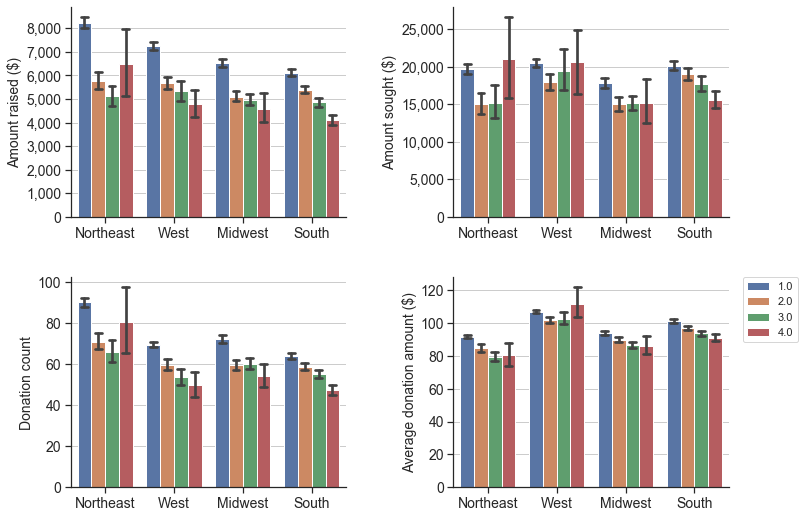

In [378]:




order = ['Northeast','West','Midwest','South']

import matplotlib

fig, axes = plt.subplots(2, 2, figsize=(12,8))


for row in axes:
    for ax in row:
        ax.grid(zorder=0)

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='current_amount',order=order, ax=axes[0,0],hue='ndi_quantile', capsize=0.1)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), size=14)
axes[0,0].set_yticklabels(axes[0,0].get_yticks().astype(int), size=14)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Amount raised ($)', size=14)
axes[0,0].yaxis.grid(True)
axes[0,0].get_legend().remove()
axes[0,0].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='goal_amount', order=order, ax=axes[0,1],hue='ndi_quantile', capsize=0.1)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), size=14)
axes[0,1].set_yticklabels(axes[0,1].get_yticks().astype(int), size=14)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Amount sought ($)', size=14)
axes[0,1].yaxis.grid(True)
axes[0,1].get_legend().remove()
axes[0,1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='donation_count', order=order, ax=axes[1,0], hue='ndi_quantile', capsize=0.1)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), size=14)
axes[1,0].set_yticklabels(axes[1,0].get_yticks().astype(int), size=14)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Donation count', size=14)
axes[1,0].yaxis.grid(True)
axes[1,0].get_legend().remove()
sns.despine()

sns.set(style="ticks")
sns.barplot(data=master, x='census_region', y='donation_mean', order=order, ax=axes[1,1], hue='ndi_quantile', capsize=0.1)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), size=14)
axes[1,1].set_yticklabels(axes[1,1].get_yticks().astype(int), size=14)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Average donation amount ($)', size=14)
axes[1,1].yaxis.grid(True)
#axes[1,1].get_legend().remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()


fig.tight_layout(pad=3)

fig.savefig('../plots/figure_3_with_cdi.eps')



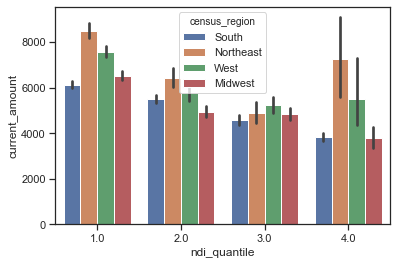

In [72]:
sns.barplot(x='ndi_quantile',y='current_amount',data=master,hue='census_region')

In [181]:
master[(master['ndi_quantile'] == 4)&(master['census_region'] == 'Northeast')]['county_name'].value_counts()

Bronx County, New York    117
Somerset County, Maine      9
Name: county_name, dtype: int64

In [129]:
master[(master['ndi_quantile'] == 4)&(master['census_region'] == 'West')]['county_name'].value_counts()

Tulare County, California            82
Doña Ana County, New Mexico          51
Yuma County, Arizona                 39
San Juan County, New Mexico          29
Imperial County, California          27
Roosevelt County, New Mexico         24
Tehama County, California            20
Apache County, Arizona               16
Taos County, New Mexico              15
Lincoln County, Montana              13
Otero County, New Mexico             12
Chaves County, New Mexico            11
Torrance County, New Mexico          10
McKinley County, New Mexico           9
Navajo County, Arizona                8
Alamosa County, Colorado              8
Malheur County, Oregon                7
San Miguel County, New Mexico         6
Modoc County, California              6
La Paz County, Arizona                5
Rio Arriba County, New Mexico         5
Rio Grande County, Colorado           5
Hidalgo County, New Mexico            4
Colfax County, New Mexico             4
Santa Cruz County, Arizona            4


In [61]:
pd.crosstab(master['ndi_quantile'],master['census_region'])

census_region,Midwest,Northeast,South,West
ndi_quantile,,,,
1.0,11058,10921,15642,17809
2.0,4307,2326,9665,4237
3.0,2407,779,5106,1344
4.0,331,131,3090,484


In [224]:
master[['goal_amount_winsor_25',
        'current_amount_winsor_25',
        'per_raised_winsor_25',
        'donation_count_winsor_25',
        'donation_amount_winsor_25',
        'census_region']].groupby(['census_region']).mean().T.round(3)

census_region,Midwest,Northeast,South,West
goal_amount_winsor_25,16201.145,18743.923,18046.915,19653.003
current_amount_winsor_25,5858.042,7441.853,5522.943,6729.798
per_raised_winsor_25,0.554,0.601,0.496,0.534
donation_count_winsor_25,64.712,81.728,57.514,64.678
donation_amount_winsor_25,94.972,92.943,101.550,109.148


In [225]:
fin_by_reg = master[['goal_amount_winsor_25',
        'current_amount_winsor_25',
        'per_raised_winsor_25',
        'donation_count_winsor_25',
        'donation_amount_winsor_25',
        'census_region']].groupby(['census_region']).agg(['mean','count','std'])

import math

ci95_hi = []
ci95_lo = []

for i in fin_by_reg.index:
    m, c, s = fin_by_reg.loc[i][0:3]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))
    
fin_by_reg['goal_amount_winsor_25','ci95_hi'] = ci95_hi
fin_by_reg['goal_amount_winsor_25','ci95_lo'] = ci95_lo

ci95_hi = []
ci95_lo = []

for i in fin_by_reg.index:
    m, c, s = fin_by_reg.loc[i][3:6]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

fin_by_reg['current_amount_winsor_25','ci95_hi'] = ci95_hi
fin_by_reg['current_amount_winsor_25','ci95_lo'] = ci95_lo

ci95_hi = []
ci95_lo = []

for i in fin_by_reg.index:
    m, c, s = fin_by_reg.loc[i][6:9]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

fin_by_reg['per_raised_winsor_25','ci95_hi'] = ci95_hi
fin_by_reg['per_raised_winsor_25','ci95_lo'] = ci95_lo

ci95_hi = []
ci95_lo = []

for i in fin_by_reg.index:
    m, c, s = fin_by_reg.loc[i][9:12]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

fin_by_reg['donation_count_winsor_25','ci95_hi'] = ci95_hi
fin_by_reg['donation_count_winsor_25','ci95_lo'] = ci95_lo

ci95_hi = []
ci95_lo = []

for i in fin_by_reg.index:
    m, c, s = fin_by_reg.loc[i][12:15]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

fin_by_reg['donation_amount_winsor_25','ci95_hi'] = ci95_hi
fin_by_reg['donation_amount_winsor_25','ci95_lo'] = ci95_lo


In [231]:
fin_by_reg_ref = fin_by_reg.T.reset_index().sort_values('level_0')

In [236]:
fin_by_reg_ref_mean = fin_by_reg_ref[fin_by_reg_ref['level_1'] == 'mean']
fin_by_reg_ref_mean.index=fin_by_reg_ref_mean['level_0']
del fin_by_reg_ref_mean['level_0']
del fin_by_reg_ref_mean['level_1']

fin_by_reg_ref_cilo = fin_by_reg_ref[fin_by_reg_ref['level_1'] == 'ci95_lo']
fin_by_reg_ref_cilo.index=fin_by_reg_ref_cilo['level_0']
del fin_by_reg_ref_cilo['level_0']
del fin_by_reg_ref_cilo['level_1']

fin_by_reg_ref_cihi = fin_by_reg_ref[fin_by_reg_ref['level_1'] == 'ci95_hi']
fin_by_reg_ref_cihi.index=fin_by_reg_ref_cihi['level_0']
del fin_by_reg_ref_cihi['level_0']
del fin_by_reg_ref_cihi['level_1']

In [243]:
fin_by_reg_ref_mean.round(2).astype(str).add(' (').add(fin_by_reg_ref_cilo.round(2).astype(str)).add(' - ').add(fin_by_reg_ref_cihi.round(2).astype(str)).add(')')

census_region,Midwest,Northeast,South,West
level_0,,,,
current_amount_winsor_25,5858.04 (5747.75 - 5968.33),7441.85 (7286.61 - 7597.1),5522.94 (5441.89 - 5603.99),6729.8 (6617.77 - 6841.83)
donation_amount_winsor_25,94.97 (94.06 - 95.88),92.94 (91.95 - 93.93),101.55 (100.81 - 102.29),109.15 (108.25 - 110.05)
donation_count_winsor_25,64.71 (63.63 - 65.8),81.73 (80.24 - 83.21),57.51 (56.75 - 58.28),64.68 (63.69 - 65.67)
goal_amount_winsor_25,16201.14 (15859.59 - 16542.7),18743.92 (18305.01 - 19182.84),18046.92 (17761.51 - 18332.32),19653.0 (19303.82 - 20002.18)
per_raised_winsor_25,0.55 (0.55 - 0.56),0.6 (0.59 - 0.61),0.5 (0.49 - 0.5),0.53 (0.53 - 0.54)


Hit goal by census region

In [274]:
hit_goal_df = pd.crosstab(master['hit_goal'],master['census_region']).T

In [275]:
hit_goal_df.columns.name = ''

In [276]:
hit_goal_df['sum'] = hit_goal_df.apply(lambda x: x.sum(), axis=1)
hit_goal_df['per'] = hit_goal_df[1]/hit_goal_df['sum']
hit_goal_df['together'] = hit_goal_df['sum'].round(1).astype(str).add(' (').add(hit_goal_df['per'].round(2).astype(str)).add(')')
hit_goal_df

,0,1,sum,per,together
census_region,,,,,
Midwest,11283,2162,13445,0.160803,13445 (0.16)
Northeast,8325,1965,10290,0.190962,10290 (0.19)
South,20500,3082,23582,0.130693,23582 (0.13)
West,14345,2554,16899,0.151133,16899 (0.15)


Normalized distribution of campaign year by census region

In [49]:
cont = pd.crosstab(master['year'], master['census_region']).apply(lambda r: r/r.sum(), axis=1).round(4) * 100

In [50]:
cont = cont.reset_index().melt(id_vars=['year'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


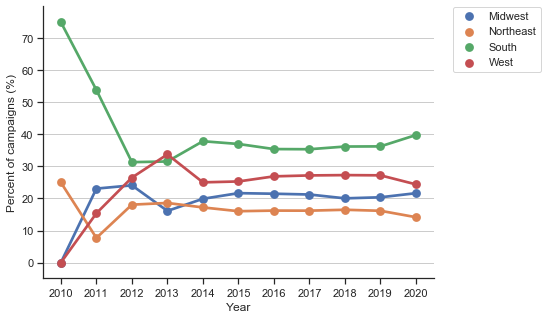

In [55]:
# sns.pointplot(x='year',y='value',hue='census_region',data=cont)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlabel('Year')
# plt.ylabel('Percent of campaigns (%)')
# sns.despine()
# plt.savefig("../plots/census_by_year.eps", bbox_inches='tight')



fig, ax = plt.subplots(figsize=(7,5))
sns.pointplot(x='year', y='value', hue='census_region', data=cont, join=True, scale=1, ax=ax)
ax.set_ylabel('Percent of campaigns (%)')
ax.set_xlabel('Year')
ax.yaxis.grid(True)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../plots/census_by_year.eps", bbox_inches='tight')

Distribution of amount raised by year

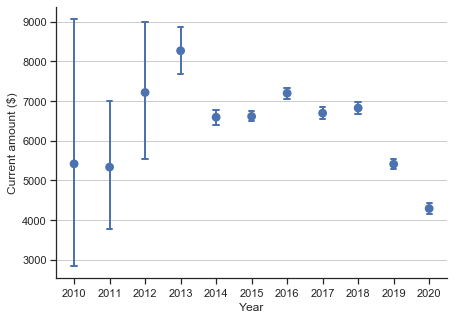

In [253]:
fig, ax = plt.subplots(figsize=(7,5))
sns.pointplot(x='year', y='current_amount_winsor_25', data=master, join=False, capsize=0.15, scale=1, errwidth=2, ax=ax)
ax.set_ylabel('Current amount ($)')
ax.set_xlabel('Year')
ax.yaxis.grid(True)
sns.despine()
fig.savefig('../plots/current_amt_by_year.eps')

# Statistics

### Other tests

In [139]:
from scipy.stats import chi2_contingency

cont = pd.crosstab(master['hit_goal'], master['census_region'])

g, p, dof, expctd = chi2_contingency(cont)

g,p

(196.96220907741292, 1.9121398559149487e-42)

In [142]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('goal_amount_winsor_25 ~ C(census_region)', data=master).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table['PR(>F)'])

# Ordinary Least Squares (OLS) model
model = ols('current_amount_winsor_25 ~ C(census_region)', data=master).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table['PR(>F)'])

# Ordinary Least Squares (OLS) model
model = ols('donation_count_winsor_25 ~ C(census_region)', data=master).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table['PR(>F)'])

# Ordinary Least Squares (OLS) model
model = ols('donation_amount_winsor_25 ~ C(census_region)', data=master).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table['PR(>F)'])

# Ordinary Least Squares (OLS) model
model = ols('per_raised_winsor_25 ~ C(census_region)', data=master).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table['PR(>F)'])

C(census_region)    1.891025e-38
Residual                     NaN
Name: PR(>F), dtype: float64
C(census_region)    1.767827e-133
Residual                      NaN
Name: PR(>F), dtype: float64
C(census_region)    1.140591e-193
Residual                      NaN
Name: PR(>F), dtype: float64
C(census_region)    1.588785e-141
Residual                      NaN
Name: PR(>F), dtype: float64
C(census_region)    9.965086e-91
Residual                     NaN
Name: PR(>F), dtype: float64


### Regressions

#### Donation amount

In [33]:
# formula = '''donation_mean ~  
# C(year) + 
# C(census_region) + 
# goal_amount + 
# C(d_cardiovascular_diseases) + 
# C(d_endocrine_diseases) + 
# C(d_gastrointestinal_diseases) + 
# C(d_genitourinary_diseases) + 
# C(d_infections) + 
# C(d_injuries_and_external_causes) + 
# C(d_mental_behavioral_and_substance_use_disorders) + 
# C(d_musculoskeletal_diseases) + 
# C(d_neoplasms) + 
# C(d_nervous_system_diseases) + 
# C(d_respiratory_diseases) +
# has_internet +
# no_health_insurance +
# unemployment_rate +
# percent_poverty
# '''.replace('\n','')

In [186]:
formula = '''donation_mean ~  
C(year) + 
C(census_region) + 
goal_amount + 
C(d_cardiovascular_diseases) + 
C(d_endocrine_diseases) + 
C(d_gastrointestinal_diseases) + 
C(d_genitourinary_diseases) + 
C(d_infections) + 
C(d_injuries_and_external_causes) + 
C(d_mental_behavioral_and_substance_use_disorders) + 
C(d_musculoskeletal_diseases) + 
C(d_neoplasms) + 
C(d_nervous_system_diseases) + 
C(d_respiratory_diseases) +
C(ndi_quantile)
'''.replace('\n','')

In [187]:
formula

'donation_mean ~  C(year) + C(census_region) + goal_amount + C(d_cardiovascular_diseases) + C(d_endocrine_diseases) + C(d_gastrointestinal_diseases) + C(d_genitourinary_diseases) + C(d_infections) + C(d_injuries_and_external_causes) + C(d_mental_behavioral_and_substance_use_disorders) + C(d_musculoskeletal_diseases) + C(d_neoplasms) + C(d_nervous_system_diseases) + C(d_respiratory_diseases) +C(ndi_quantile)'

In [188]:
gamma_model = sm.GLM.from_formula(formula=formula, data=master, family=sm.families.Gamma(sm.families.links.log()))

In [189]:
gamma_results = gamma_model.fit()

In [190]:
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          donation_mean   No. Observations:                87468
Model:                            GLM   Df Residuals:                    87439
Model Family:                   Gamma   Df Model:                           28
Link Function:                    log   Scale:                         0.39407
Method:                          IRLS   Log-Likelihood:            -4.5973e+05
Date:                Tue, 16 Mar 2021   Deviance:                       22843.
Time:                        11:50:56   Pearson chi2:                 3.45e+04
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [215]:
gam_html = gamma_results.summary().as_html()

In [217]:
gam_df = pd.read_html(gam_html, header=0)[1]

In [218]:
gam_df.head()

,Unnamed: 0,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,4.0912,0.676,6.056,0.000,2.767,5.415
1,C(year)[T.2011],0.3644,0.740,0.492,0.622,-1.086,1.814
2,C(year)[T.2012],0.5348,0.693,0.772,0.440,-0.823,1.893
3,C(year)[T.2013],0.5206,0.678,0.768,0.442,-0.807,1.849
4,C(year)[T.2014],0.4938,0.676,0.731,0.465,-0.831,1.818


In [219]:
def AddBeta(df):
    beta = df['coef'].round(2).astype(str) + ' (' + df['std err'].round(2).astype(str) + ')'
    return beta

def AddPer(df):
    exp_coef = np.exp(df['coef'])
    exp_low = np.exp(df['[0.025'])
    exp_high = np.exp(df['0.975]'])
    
    r = exp_coef.round(2).astype(str) + ' (' + exp_low.round(2).astype(str) + ', ' + exp_high.round(2).astype(str) + ')'
    
    return r

In [221]:
AddBeta(gam_df)

0      4.09 (0.68)
1      0.36 (0.74)
2      0.53 (0.69)
3      0.52 (0.68)
4      0.49 (0.68)
5      0.41 (0.68)
6      0.45 (0.68)
7      0.53 (0.68)
8       0.5 (0.68)
9      0.35 (0.68)
10     0.22 (0.68)
11      0.0 (0.02)
12      0.1 (0.02)
13     0.16 (0.02)
14     0.04 (0.02)
15     0.02 (0.03)
16     0.07 (0.03)
17    -0.01 (0.03)
18     0.03 (0.02)
19    -0.02 (0.02)
20     0.03 (0.03)
21      0.0 (0.03)
22     0.06 (0.01)
23     0.04 (0.02)
24     0.05 (0.03)
25    -0.03 (0.01)
26    -0.08 (0.02)
27     -0.1 (0.03)
28       0.0 (0.0)
dtype: object

#### Donation count

In [191]:
formula = '''donation_count ~  
C(year) + 
C(census_region) + 
goal_amount + 
C(d_cardiovascular_diseases) + 
C(d_endocrine_diseases) + 
C(d_gastrointestinal_diseases) + 
C(d_genitourinary_diseases) + 
C(d_infections) + 
C(d_injuries_and_external_causes) + 
C(d_mental_behavioral_and_substance_use_disorders) + 
C(d_musculoskeletal_diseases) + 
C(d_neoplasms) + 
C(d_nervous_system_diseases) + 
C(d_respiratory_diseases) +
ndi_quantile
'''.replace('\n','')

In [192]:
pois_model = sm.GLM.from_formula(formula=formula, data=master, family=sm.families.Poisson())

In [193]:
pois_results = pois_model.fit()

In [194]:
print(pois_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         donation_count   No. Observations:                87468
Model:                            GLM   Df Residuals:                    87439
Model Family:                 Poisson   Df Model:                           28
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8916e+06
Date:                Tue, 16 Mar 2021   Deviance:                   5.2969e+06
Time:                        11:51:26   Pearson chi2:                 8.76e+06
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [112]:
pois_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.9027,0.050,17.985,0.000,0.804,1.001
C(year)[T.2011],-0.1323,0.053,-2.477,0.013,-0.237,-0.028
C(year)[T.2012],0.2877,0.049,5.896,0.000,0.192,0.383
C(year)[T.2013],0.3106,0.048,6.477,0.000,0.217,0.405
C(year)[T.2014],0.0526,0.048,1.099,0.272,-0.041,0.146
C(year)[T.2015],0.1077,0.048,2.252,0.024,0.014,0.202
C(year)[T.2016],0.1443,0.048,3.016,0.003,0.051,0.238
C(year)[T.2017],0.0266,0.048,0.556,0.578,-0.067,0.120
C(year)[T.2018],0.0515,0.048,1.076,0.282,-0.042,0.145
C(year)[T.2019],-0.1785,0.048,-3.730,0.000,-0.272,-0.085


#### Amount raised

In [390]:
formula = '''current_amount ~  
year + 
goal_amount +
census_region + 
d_cardiovascular_diseases + 
d_endocrine_diseases + 
d_gastrointestinal_diseases + 
d_genitourinary_diseases + 
d_infections + 
d_injuries_and_external_causes + 
d_mental_behavioral_and_substance_use_disorders + 
d_musculoskeletal_diseases + 
d_neoplasms + 
d_nervous_system_diseases + 
d_respiratory_diseases +
ndi_quantile
'''.replace('\n','')

In [391]:
formula

'current_amount ~  year + goal_amount +census_region + d_cardiovascular_diseases + d_endocrine_diseases + d_gastrointestinal_diseases + d_genitourinary_diseases + d_infections + d_injuries_and_external_causes + d_mental_behavioral_and_substance_use_disorders + d_musculoskeletal_diseases + d_neoplasms + d_nervous_system_diseases + d_respiratory_diseases +ndi_quantile'

Find var_power that maximizes log-likelihood

In [118]:
%%time

power = []
ll = []
for p in range(110,200,5):
    tweedie_model = sm.GLM.from_formula(formula=formula, data=master, family=sm.genmod.families.family.Tweedie(var_power=p/100, eql=True))
    tweedie_results = tweedie_model.fit()
    llf = tweedie_model.loglike(tweedie_results.params)
    power.append(p/100)
    ll.append(llf)

CPU times: user 2min 40s, sys: 23.7 s, total: 3min 4s
Wall time: 1min 49s


In [119]:
tweedie = pd.DataFrame({'power':power,'ll':ll})
tweedie.to_csv('../data/tweedie.csv', index=False)

In [120]:
tweedie.sort_values('ll', ascending=False).head(5)

,power,ll
9,1.55,-944184.961866
10,1.60,-944190.871829
8,1.50,-944237.637705
11,1.65,-944264.126696
7,1.45,-944343.499511


Run model using p=1.55

In [392]:
tweedie_model = sm.GLM.from_formula(formula=formula, data=master, family=sm.genmod.families.family.Tweedie(var_power=1.55, eql=True))

In [393]:
tweedie_results = tweedie_model.fit()

In [394]:
print(tweedie_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         current_amount   No. Observations:                87468
Model:                            GLM   Df Residuals:                    87439
Model Family:                 Tweedie   Df Model:                           28
Link Function:                    log   Scale:                          69.665
Method:                          IRLS   Log-Likelihood:            -8.8004e+05
Date:                Tue, 16 Mar 2021   Deviance:                   3.9340e+06
Time:                        14:02:21   Pearson chi2:                 6.09e+06
No. Iterations:                    31                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [395]:
twe_html = tweedie_results.summary().as_html()

In [396]:
twe_df = pd.read_html(twe_html, header=0)[1]

In [397]:
twe_df.head()

,Unnamed: 0,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,8.3253,0.500,16.663,0.000,7.346,9.304
1,year[T.2011],-0.1320,0.546,-0.242,0.809,-1.202,0.938
2,year[T.2012],0.3461,0.510,0.679,0.497,-0.654,1.346
3,year[T.2013],0.3589,0.501,0.717,0.474,-0.623,1.340
4,year[T.2014],0.1771,0.500,0.354,0.723,-0.802,1.157


In [399]:
twe_df.columns = ['var','coef','std err','z','P>|z|','[0.025','0.975]']

In [406]:
def AddBeta(df):
    beta = df['coef'].round(2).astype(str) + ' (' + df['std err'].round(2).astype(str) + ')'
    res = pd.concat([df['var'],beta],axis=1)
    return res

def AddPer(df):
    exp_coef = np.exp(df['coef']) - 1
    exp_low = np.exp(df['[0.025']) - 1
    exp_high = np.exp(df['0.975]']) - 1
    
    r = exp_coef.round(2).astype(str) + ' (' + exp_low.round(2).astype(str) + ', ' + exp_high.round(2).astype(str) + ')'
    res = pd.concat([df['var'],r],axis=1)
    return res

In [409]:
46551+11895+4979

63425

### Analyze social media shares missing data

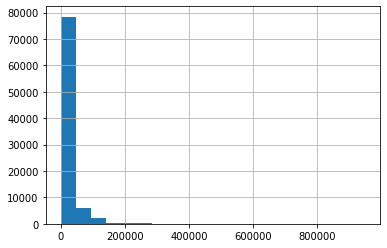

In [201]:
master['goal_amount'].hist(bins=20)

In [218]:
shares.shape

(92962, 4)

In [219]:
master.shape

(86747, 127)

In [220]:
shares = shares.drop_duplicates('url')

In [221]:
shares.shape

(88666, 4)

In [222]:
master = master.merge(shares, on='url', how='inner')

In [223]:
master.shape

(82725, 130)

In [224]:
master.loc[:,'missing_shares'] = master['shares'].isna()

In [225]:
pd.crosstab(master['resp'], master['missing_shares'])

missing_shares,False,True
resp,,
200.0,72377,10211
404.0,0,129
502.0,0,4


In [226]:
pd.crosstab(master['year'], master['missing_shares'])

missing_shares,False,True
year,,
2010,6,0
2011,27,3
2012,101,6
2013,802,68
2014,5767,570
2015,14571,1051
2016,11712,675
2017,9258,324
2018,10021,485


In [185]:
master[master['missing_shares'] == True]['year'].value_counts(normalize=True).sort_index()

2011    0.000397
2012    0.000662
2013    0.007415
2014    0.058395
2015    0.105535
2016    0.063559
2017    0.031780
2018    0.050053
2019    0.400689
2020    0.281515
Name: year, dtype: float64

In [186]:
 master[master['missing_shares'] != True]['year'].value_counts(normalize=True).sort_index()

2010    0.000075
2011    0.000428
2012    0.001378
2013    0.011827
2014    0.082418
2015    0.205215
2016    0.163308
2017    0.127212
2018    0.143174
2019    0.147327
2020    0.117638
Name: year, dtype: float64

# Export data for Matt

In [53]:
list_to_sub = [
    'url',
    'year',
    'census_region',
    'd_cardiovascular_diseases',
    'd_endocrine_diseases',
    'd_gastrointestinal_diseases',
    'd_genitourinary_diseases',
    'd_infections',
    'd_injuries_and_external_causes',
    'd_mental_behavioral_and_substance_use_disorders',
    'd_musculoskeletal_diseases',
    'd_neoplasms',
    'd_nervous_system_diseases',
    'd_respiratory_diseases',
    'has_internet',
    'no_health_insurance',
    'unemployment_rate',
    'percent_poverty',
    'current_amount',
    'current_amount_winsor_1',
    'current_amount_winsor_25',
    'current_amount_winsor_5',
    'goal_amount',
    'goal_amount_winsor_1',
    'goal_amount_winsor_25',
    'goal_amount_winsor_5',
    'donation_count',
    'donation_count_winsor_1',
    'donation_count_winsor_25',
    'donation_count_winsor_5',
    'don_mean',
    'donation_amount_winsor_1',
    'donation_amount_winsor_25',
    'donation_amount_winsor_5'
]

In [54]:
matt = master[list_to_sub]

In [55]:
matt.rename(columns={'don_mean': 'donation_amount'}, inplace=True)

In [57]:
matt.to_csv('../for_matt/cf_data.csv', index=False)

### Check if any urls were left out of algorithm

In [1]:
import json
import pandas as pd

In [2]:
with open('../not_currently_using/spark-jsl-ccsr/input_data/feed_chunk_1.json') as f:
    chunk_1 = json.load(f)
    df_1 = pd.DataFrame(chunk_1)

with open('../not_currently_using/spark-jsl-ccsr/input_data/feed_chunk_2.json') as f:
    chunk_2 = json.load(f)
    df_2 = pd.DataFrame(chunk_2)
    
with open('../not_currently_using/spark-jsl-ccsr/input_data/feed_chunk_3.json') as f:
    chunk_3 = json.load(f)
    df_3 = pd.DataFrame(chunk_3)
    
with open('../not_currently_using/spark-jsl-ccsr/input_data/feed_chunk_4.json') as f:
    chunk_4 = json.load(f)
    df_4 = pd.DataFrame(chunk_4)

In [3]:
er = pd.concat([df_1,df_2,df_3,df_4])

In [30]:
deid = pd.read_csv('../data/disease_categorization/url_deid_map.csv')

In [33]:
deid.head()

,url,url_deid
0,https://www.gofundme.com/f/Amarilindo,0
1,https://www.gofundme.com/f/m6gg66vd,1
2,https://www.gofundme.com/f/2vhyamk,2
3,https://www.gofundme.com/f/support-loving-moth...,3
4,https://www.gofundme.com/f/Aeolis_Est,4


In [34]:
er.columns = ['text','url_deid']

In [35]:
er = er.merge(deid, on='url_deid', how='left')

In [36]:
er.shape

(89493, 3)

In [16]:
master.columns

Index(['index', 'url', 'donation_count', 'donor_reached_max', 'currencycode',
       'current_amount', 'goal_amount', 'fund_name', 'created_at',
       'social_share_last_update', 'city', 'country', 'postal_code', 'is_team',
       'state_raw', 'zip_len', 'zip', 'county_fips_5', 'year', 'month',
       'county_name', 'total_population', 'unemployment_rate', 'median_income',
       'percent_poverty', 'no_health_insurance', 'public_health_insurance',
       'private_health_insurance', 'ed_percent_highschool',
       'ed_percent_bachelors', 'has_internet', 'percent_less_10k',
       'percent_10k_15k', 'percent_15k_25k', 'percent_25k_35k',
       'percent_white', 'percent_under_5', 'percent_5_to_9',
       'percent_10_to_14', 'percent_15_to_19', 'percent_20_to_24',
       'percent_25_to_34', 'percent_35_to_44', 'percent_45_to_54',
       'percent_55_to_59', 'percent_60_to_64', 'percent_65_to_74',
       'percent_75_to_84', 'percent_85_over', 'percent_65_and_over',
       'percent_18_and_ov

In [37]:
er_url = er['url'].unique().tolist()
m_url = master['url'].unique().tolist()

In [45]:
len(set(er_url).difference(set(m_url)))

729

# Old code

In [324]:
disease_cat_melt = disease_pivot_sub.melt(id_vars=['url'])

In [329]:
disease_cat_melt.columns = ['url','cat','present']

In [332]:
a.loc[:,'present_lab'] = ['present' if x == 1 else 'absent' for x in a['present']]

In [336]:
a.replace({'Mental, behavioral, and substance use disorders':'Mental and substance use disorders'}, inplace=True)